In [1]:
"""
一、项目说明：
此为 Kaggle平台--共享单车项目;
包含天气、温度、季节、使用时刻等数据；
本项目旨在，通过特征工程、模型训练等，预测华盛顿共享单车租赁需求，以提高单车利用率；
"""

'\n一、项目说明：\n此为 Kaggle平台--共享单车项目;\n包含天气、温度、季节、使用时刻等数据；\n本项目旨在，通过特征工程、模型训练等，预测华盛顿共享单车租赁需求，以提高单车利用率；\n'

In [2]:
""" 
二、数据集说明：
包括训练集 train表、测试集 test表；
train表，由每月前19天数据组成；
test表，由每月20号至当月月底数据组成；
"""

' \n二、数据集说明：\n包括训练集 train表、测试集 test表；\ntrain表，由每月前19天数据组成；\ntest表，由每月20号至当月月底数据组成；\n'

In [3]:
# 三、数据分析
# 3-1 导入相关库
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")#忽略警告
from datetime import datetime as dt
from matplotlib.font_manager import fontManager as fm
import matplotlib
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error # MSE 均方误差：预测值与真实值的差值的平方的平均值
from sklearn.metrics import mean_absolute_error # MAE 平均绝对误差：预测值与真实值的差值的绝对误差的平均值
from sklearn.metrics import r2_score # R2决定系数
from sklearn import preprocessing
pd.set_option('display.max_columns',None)

In [4]:
# 3-2 导入数据
df_train = pd.read_csv('/kaggle/input/bike-sharing-demand/train.csv')
df_test = pd.read_csv('/kaggle/input/bike-sharing-demand/test.csv')

In [5]:
# 3-3 查找是否存在缺失值
# 可以通过查看 entries来查看是否存在缺失值;
# 可以发现，train表 10886个样本，test表 6493个样本，均无缺失值；
print(df_train.info())
print('-'* 70)
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB
None
----------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      ------------

In [6]:
# 3-4 特征说明
# datetime：时间；
# season：季节；1：春天，2：夏天，3：秋天，4：冬天；
# holiday：是否节假日；1：是，0：否；
# workingday：是否工作日；1：是，0：否；
# weather：天气概况；1：晴、少云，2：薄雾+云，3：小雨小雪，4：大雨雷暴大雪等；
# temp：实际温度；
# atemp：相对温度；
# humidity：湿度；
# windspeed：风速；
# casual：未注册用户租赁量
# registered：已注册用户租赁量
# count：总租赁量；

In [7]:
# 3-5 检查数据异常情况
# 3-5-1
# 数据概览
print(df_train.describe())
# 重点观测下，数据波动情况，即std行；
# 各特征列的波动基本不大;
# 但预测项，即，casual、registered、count列，
# 相对其均值来说，标准差很大，需对其进行处理；
# 且，由于count列是，注册、非注册用户的总租赁量，因此以此来剔除异常数据；

             season       holiday    workingday       weather         temp  \
count  10886.000000  10886.000000  10886.000000  10886.000000  10886.00000   
mean       2.506614      0.028569      0.680875      1.418427     20.23086   
std        1.116174      0.166599      0.466159      0.633839      7.79159   
min        1.000000      0.000000      0.000000      1.000000      0.82000   
25%        2.000000      0.000000      0.000000      1.000000     13.94000   
50%        3.000000      0.000000      1.000000      1.000000     20.50000   
75%        4.000000      0.000000      1.000000      2.000000     26.24000   
max        4.000000      1.000000      1.000000      4.000000     41.00000   

              atemp      humidity     windspeed        casual    registered  \
count  10886.000000  10886.000000  10886.000000  10886.000000  10886.000000   
mean      23.655084     61.886460     12.799395     36.021955    155.552177   
std        8.474601     19.245033      8.164537     49.96047

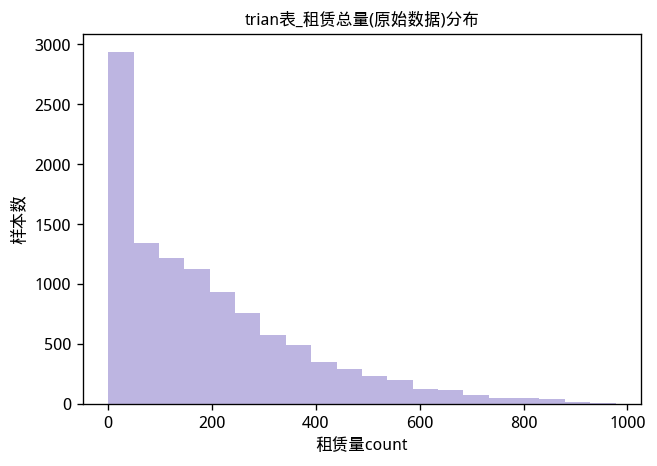

In [8]:
# 3-5-2
# 可先通过条形图，概览下该列;
# 图中可见，处于极小值0-50的，样本数极多，过于集中；
# 且，整体太过倾斜，需预处理；
# 注意，在kaggle或Jupyter Notebook等平台上，要正确显示中文字体，得导入内置的字体文件；
# 并全局设置为导入的字体；
fm.addfont('/kaggle/input/ygbuding/DroidSansFallback.ttf')
matplotlib.rc('font',family = 'Droid Sans Fallback',size=10)
plt.rcParams['axes.unicode_minus'] = False # 设置负号，以ASCII 字符'-'来显示，而不存在出现方块的可能性；
plt.rcParams['axes.titlesize'] = 10 # 设置字体大小
plt.figure(figsize=(6,4),dpi=120)
plt.hist(df_train['count'],bins=20,color='#bdb5e1')
plt.title('trian表_租赁总量(原始数据)分布')
plt.xlabel('租赁量count')
plt.ylabel('样本数')
plt.show()

In [9]:
# 可进一步查看，count列 0-50的样本数为 2969，极为集中;
cnt = (df_train['count'] <= 50).sum()
print('租赁count列处于0-50的样本数为 %d' % cnt)

租赁count列处于0-50的样本数为 2969


In [10]:
# 3-5-3 数据预处理
# count列做预处理；
# 1）先剔除异常数据：根据大数原则，剔除偏离均值3个标准差的数据；
train_count_mean = df_train['count'].mean()
train_count_std = df_train['count'].std()
cnt_old = len(df_train)
df_train = df_train.query('@train_count_mean - @train_count_std * 3 <= count <= @train_count_mean + @train_count_std * 3')
cnt_new = len(df_train)
cnt = cnt_old - cnt_new
print('已剔除标准差以外的样本数为 %d' % cnt) # 可见已剔除147条数据

已剔除标准差以外的样本数为 147


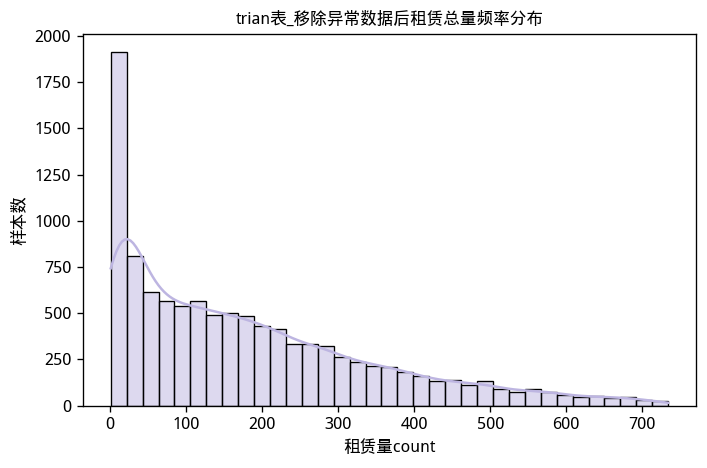

In [11]:
# 2）观察剔除异常数据后的带核密度线的直方图；
# 图中可见，偏移仍严重，需进一步处理；
ax1 = sns.displot(df_train['count'],kde = True,color='#bdb5e1')
ax1.figure.set_size_inches(6,4)
ax1.figure.set_dpi(120)
ax1.despine(top=False,right=False) # 将原默认隐藏的边框显示
plt.title('trian表_移除异常数据后租赁总量频率分布')
plt.xlabel('租赁量count')
plt.ylabel('样本数')
plt.tight_layout() # 防止title溢出画布
plt.show()

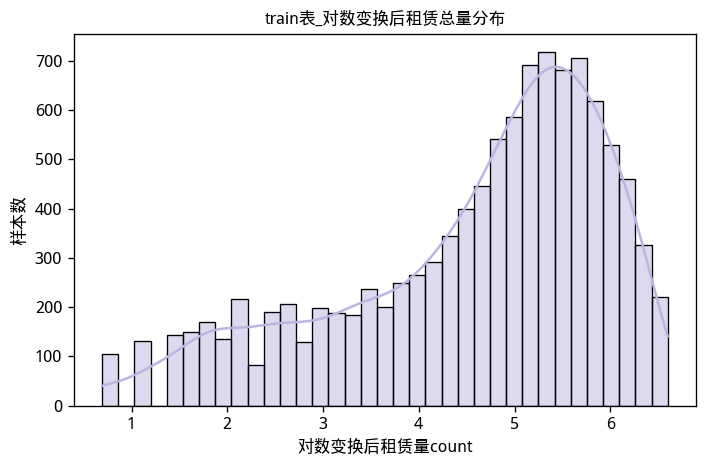

In [12]:
# 3）处理标准差过大 + 极小值过多的问题：将剔除后的count列，做log变换；
# 以期改变其倾斜趋势,改变0-50过于集中的情况；
df_y = np.log1p(df_train['count'])
ax1 = sns.displot(df_y,kde = True,color='#bdb5e1')
ax1.figure.set_size_inches(6,4)
ax1.figure.set_dpi(120)
ax1.despine(top=False,right=False)
plt.title('train表_对数变换后租赁总量分布')
plt.xlabel('对数变换后租赁量count')
plt.ylabel('样本数')
plt.tight_layout()
plt.show()
# 图中可见，log变换后，count列的分布、集中度没那么严重了，差异也相对较小了；
# 所以后面预测时，需先做log变换；

In [13]:
# 3-6 特征处理
# 由于分析的需要，可先处理时间变量，新增年、月、日、星期、时刻等列；
# 可将train表、test表结合起来，均做相应修改；
df_whole = pd.concat([df_train,df_test]).reset_index(drop=True)
print(df_whole.datetime.dtype) # 可见datetime列还不是date数据类型，可先转化
df_whole['dt1'] = df_whole['datetime'].astype('datetime64[s]')
print(df_whole['dt1'].dtype) # 可见datetime列数据类型已为 date类型

object
datetime64[s]


In [14]:
# 再者，划分出年、月、日期、星期、时间段；
df_whole['year1'] = df_whole['dt1'].dt.year
df_whole['month1'] = df_whole['dt1'].dt.month
df_whole['date1'] = df_whole['dt1'].dt.date.astype('datetime64[s]')
df_whole['weekday1'] = df_whole['dt1'].dt.weekday # 0-6：周一到周日, int64
df_whole['weekday2'] = df_whole['dt1'].dt.strftime('%A') # 返回各星期名
df_whole['hour1'] = df_whole['dt1'].dt.hour

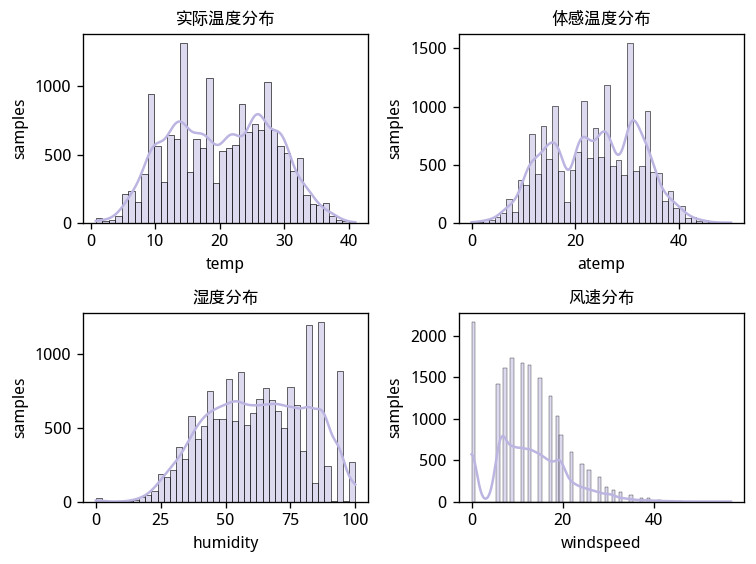

In [15]:
# 3-7 重要特征观测
# 3-7-1 概览
# 主要指温度、湿度、风速等的影响；
# 先概览下这几个特征的频率分布；
fig,axes = plt.subplots(2,2)
ax1 = sns.histplot(df_whole['temp'],kde = True,ax=axes[0,0],color='#bdb5e1')
ax2 = sns.histplot(df_whole['atemp'],kde = True,ax=axes[0,1],color='#bdb5e1')
ax3 = sns.histplot(df_whole['humidity'],kde = True,ax=axes[1,0],color='#bdb5e1')
ax4 = sns.histplot(df_whole['windspeed'],kde = True,ax=axes[1,1],color='#bdb5e1')
ax1.figure.set_dpi(120)
ax2.figure.set_dpi(120)
ax3.figure.set_dpi(120)
ax4.figure.set_dpi(120)
axes[0,0].set(xlabel = 'temp',ylabel = 'samples',title ='实际温度分布')
axes[0,1].set(xlabel = 'atemp',ylabel = 'samples',title ='体感温度分布')
axes[1,0].set(xlabel = 'humidity',ylabel = 'samples',title ='湿度分布')
axes[1,1].set(xlabel = 'windspeed',ylabel = 'samples',title ='风速分布')
plt.tight_layout() # 防止标题溢出
plt.show()

In [16]:
# 3-7-2 异常/缺失数据处理
# 分布图中，可见windspeed 在 0～6间的数据中，仅存在 0值；
print(df_whole.query('windspeed < 7')['windspeed'].unique())

[0.     6.0032]


In [17]:
# 且通过以下的查询，可知存在 2164 条数据，约占整体的13%；
# 较有可能的是，风速缺失了的均被填充为0；
print(len(df_whole.query('windspeed == 0')))

2164


In [18]:
# 因此，不能简单地将风速为0的数据剔除；
# 而需要结合其他可能影响风速的特征，来预测风速，重新修改风速为0的数据；
df_windspeed_none = df_whole.query("windspeed == 0")
df_windspeed_notnone = df_whole.query("windspeed != 0")

In [19]:
# 用随机森林预测：
# 一般来说，类似的时间段、季节、温度、湿度、天气概况等极可能影响风速；
# 因此，选择这些特征对风速进行预测；
df_speed_trainx = df_windspeed_notnone[["year1", "month1", "season", "temp",'atemp' ,"humidity", "weather"]]
df_speed_trainy = df_windspeed_notnone["windspeed"]
df_speed_testx = df_windspeed_none[["year1", "month1", "season", "temp",'atemp', "humidity", "weather"]]

In [20]:
# 用网格搜索调参
# scoring = r2，也是默认评估标准
# 由于特征选择较为简单，为了模型不过于拟合，保证一定泛化能力；
# n_estimators、min_samples_split 参数范围，暂设定如下；
# rf1 = RandomForestRegressor(random_state=10,oob_score=True) # 构建随机森林
# 用网格搜索调参
# param1 = {'n_estimators':range(500,1001,100)} # 构建最优化参数取值列表
# model1 = GridSearchCV(estimator=rf1,param_grid=param1,cv = 5)
# model1.fit(df_speed_trainx,df_speed_trainy)
# print(model1.best_score_) # 最佳得分，0.15703222775563846
# print(model1.best_params_) # 最优参数，n_estimators = 800

In [21]:
# param2 = {'min_samples_split':range(10,21,2)}
# model2 = GridSearchCV(estimator=RandomForestRegressor(random_state=10,n_estimators=800,oob_score=True),\
#                       param_grid=param2,cv = 5)
# model2.fit(df_speed_trainx,df_speed_trainy)
# print(model2.best_score_) # 最佳得分，0.23128176876850254
# print(model2.best_params_) # 最优参数，{'min_samples_split':20}

In [22]:
# 以上，选出最优参数，建立模型进行预测；
windspeed_model = RandomForestRegressor(n_estimators=800,random_state=10,min_samples_split=20,oob_score=True)
windspeed_model.fit(df_speed_trainx,df_speed_trainy)
df_speed_testy = windspeed_model.predict(df_speed_testx)
df_whole.loc[df_whole['windspeed'] == 0,'windspeed'] = df_speed_testy

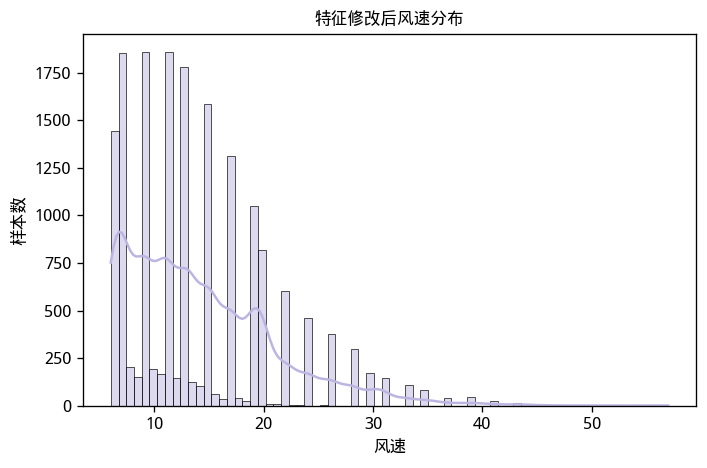

In [23]:
# 调整完，再查看下风速的特征分布；
ax1 =sns.displot(df_whole['windspeed'],kde = True,color='#bdb5e1')
ax1.figure.set_size_inches(6,4)
ax1.figure.set_dpi(120)
ax1.despine(top=False,right=False)
plt.title('特征修改后风速分布')
plt.xlabel('风速')
plt.ylabel('样本数')
plt.tight_layout()
plt.show()

In [24]:
# 3-8 特征分析- -数据可视化
# 为了分析租赁量与各特征间的关系；
# 先将已处理好的综合表，分割成原来的train表、test表；
df_train = df_whole[df_whole['count'].notna()]
df_test = df_whole[df_whole['count'].isna()]

In [25]:
# 3-8-1 时间角度
# 1、 观测一天中各时间段租赁量情况：按hour字段- -作折线图；
df_hour_mean = df_train.groupby('hour1')[['casual','registered','count']].mean().reset_index()
# 查看租赁量前3的具体时间段；
print(df_hour_mean.sort_values(by = 'count',ascending=False).head(3))

    hour1     casual  registered       count
17     17  70.508997  335.735219  406.244216
18     18  57.020000  319.405000  376.425000
8       8  20.912644  322.806897  343.719540


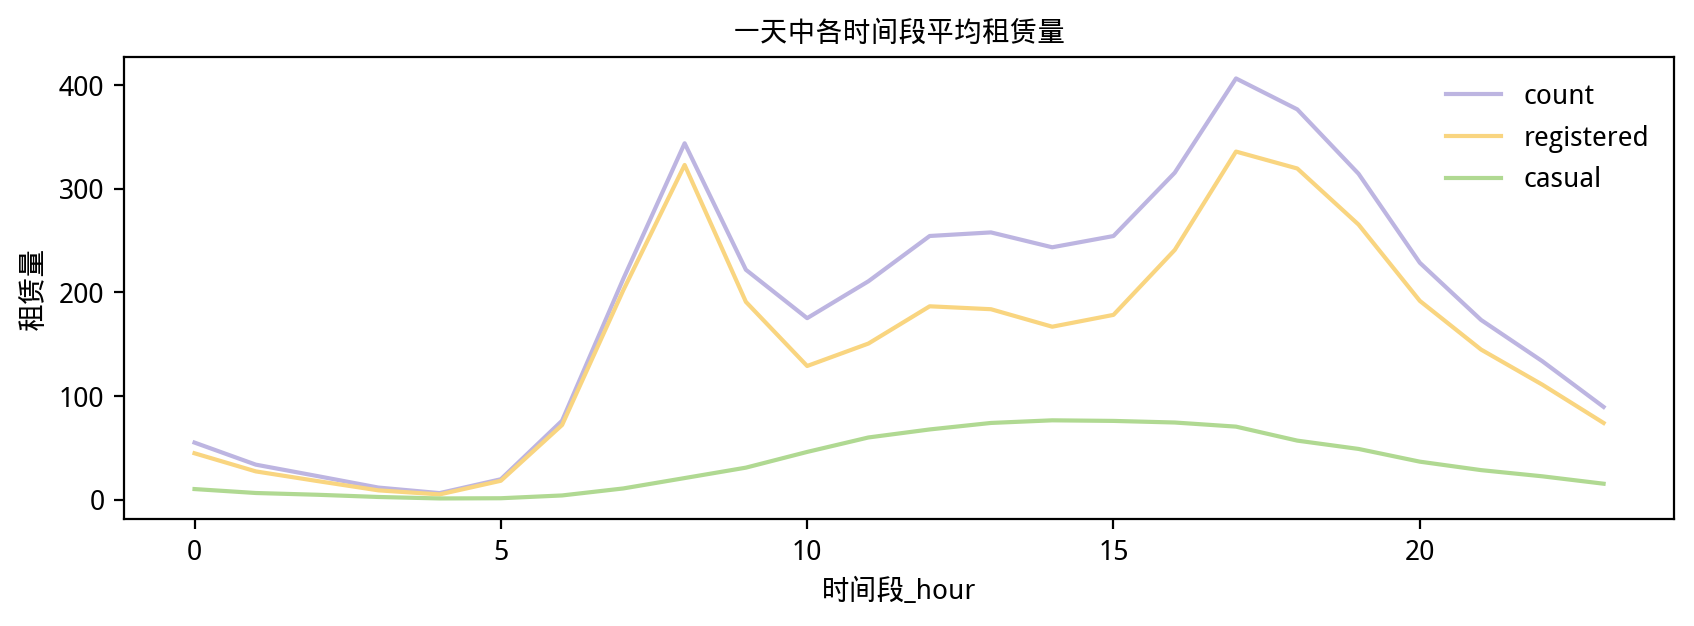

In [26]:
# 作折线图
plt.figure(figsize=(10,3),dpi=200)
plt.plot(df_hour_mean['hour1'],df_hour_mean['count'],label='count',color='#bdb5e1')
plt.plot(df_hour_mean['hour1'],df_hour_mean['registered'],label='registered',color = '#f9d580')
plt.plot(df_hour_mean['hour1'],df_hour_mean['casual'],label='casual',color = '#b0d992')
plt.title('一天中各时间段平均租赁量')
plt.xlabel('时间段_hour')
plt.ylabel('租赁量')
plt.legend(loc=1,frameon=False)
plt.show()
# 小结：以上，通过图像和查看租赁量前3的小时段，可发现：
# 1）最高时间段在 17点、18点、8点；
# 2）即，符合使用情况，一般租赁量较高的出现在早高峰、晚高峰；

In [27]:
# 2、分工作日观测 hour时间段的情况：
# 是否在所有日期，都存在早、晚高峰，将其分为工作日与否继续观测- -作折线图；
df_work = df_train[df_train['workingday'] == 1]
df_notwork = df_train.query('workingday == 0')
# 用数值分别概览下 work 与 notwork情况下，排名在前三的具体时间；
df_work_hour_mean = df_work.groupby('hour1')[['count','registered','casual']].mean()
df_notwork_hour_mean = df_notwork.groupby('hour1')[['count','registered','casual']].mean()
df1 = df_work_hour_mean.sort_values('count',ascending=False)
df2 = df_notwork_hour_mean.sort_values('count',ascending=False)
print(df1.head(3)) # 工作日，租赁量前三时段为8、17、18点；
print(df2.head(3)) # 非工作日，租赁量前三时段为13、14、12点；

            count  registered     casual
hour1                                   
8      459.451724  438.317241  21.134483
17     446.131148  402.684426  43.446721
18     424.290196  384.372549  39.917647
            count  registered      casual
hour1                                    
13     387.820690  245.462069  142.358621
14     378.731034  233.703448  145.027586
12     373.923077  246.573427  127.349650


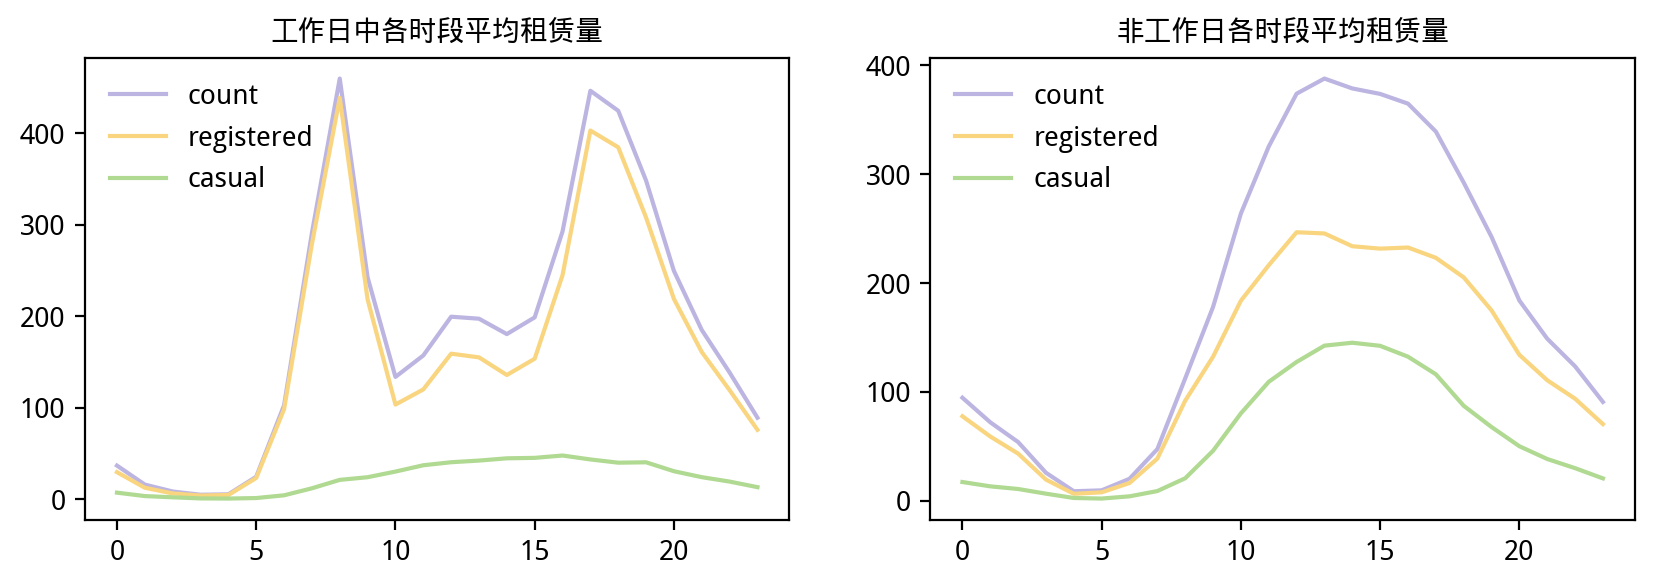

In [28]:
# 作折线图
plt.figure(figsize=(10,3),dpi=200)
plt.subplot(1,2,1) # 构建1行2列的图像
# 因为上述groupby中，未重建索引，所以默认索引为分组的hour，且为折线图的x轴；
plt.plot(df_work_hour_mean['count'],label = 'count',color = '#bdb5e1')
plt.plot(df_work_hour_mean['registered'],label = 'registered',color = '#f9d580')
plt.plot(df_work_hour_mean['casual'],label = 'casual',color = '#b0d992')
plt.title('工作日中各时段平均租赁量')
plt.legend(loc = 2,frameon=False)
plt.subplot(1,2,2)
plt.plot(df_notwork_hour_mean['count'],label = 'count',color = '#bdb5e1')
plt.plot(df_notwork_hour_mean['registered'],label = 'registered',color = '#f9d580')
plt.plot(df_notwork_hour_mean['casual'],label = 'casual',color = '#b0d992')
plt.title('非工作日各时段平均租赁量')
plt.legend(loc = 2,frameon=False)
plt.show()
# 小结：结合上图与前三租赁量的具体时间点可知
# 1）工作日的租赁量趋势基本和整体一致，均存在早高峰、晚高峰；
# 2）非工作日不存在明显的早晚高峰的现象，但中午时间段，如12-14点，是其高峰期；
# 3）是否工作日所表现出来的各时间段趋势，与实际生活也基本相符；

In [29]:
# 3、按月度观测日均租赁量
# 这里不再以小时为最小分割单位，而是天；
# 因此，需先将同日的租赁量叠加后，再计算各月份的平均租赁量；
df_temp = df_train.groupby(['year1','month1','date1'])[['count','registered','casual']].sum().reset_index()
df_temp = df_temp.groupby(['year1','month1'])[['count','registered','casual']].mean().reset_index()
# 数值来看下排名前三的具体月份：
print(df_temp.sort_values('count',ascending=False).head(3))

    year1  month1        count   registered       casual
17   2012       6  6160.684211  4725.473684  1435.210526
16   2012       5  5871.789474  4590.631579  1281.157895
19   2012       8  5810.736842  4445.263158  1365.473684


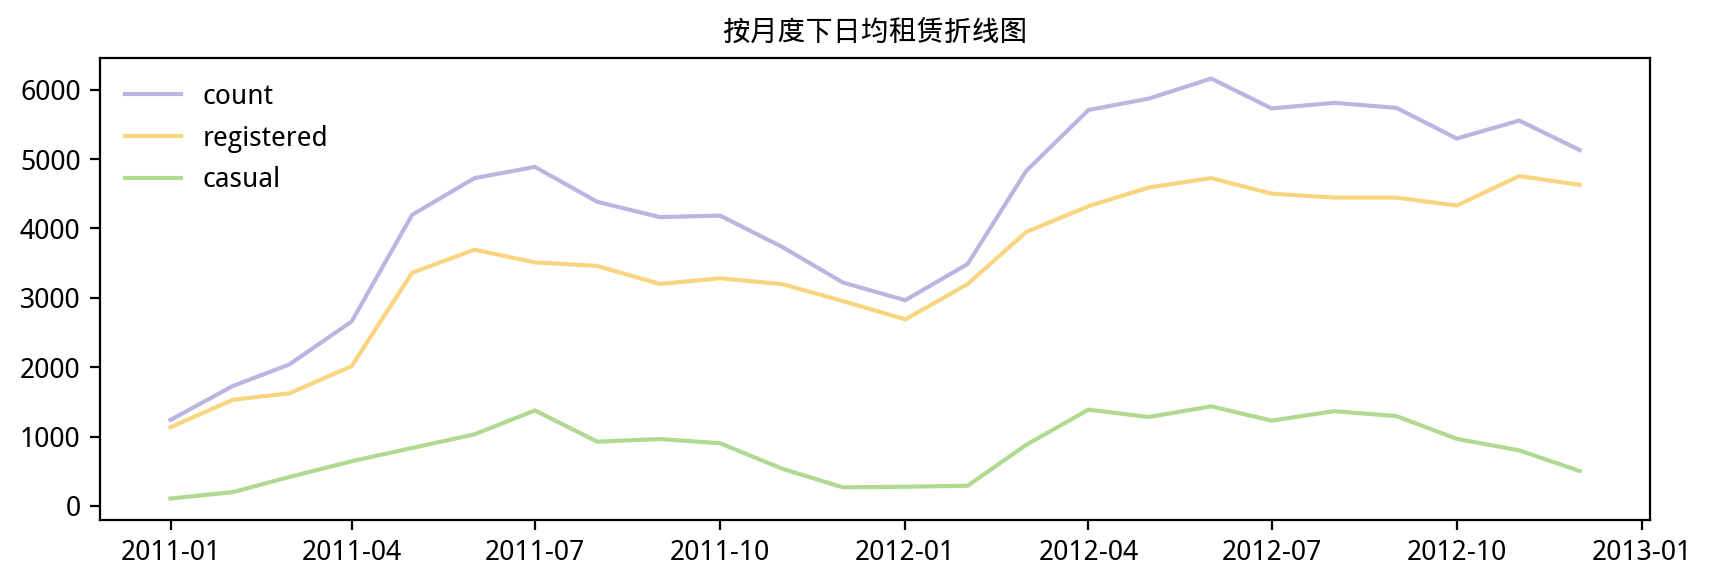

In [30]:
# 作折线图
# 为了将x轴上的月份，显示为日期形式，我们可以取为每个月份的1号；
df_temp['rq'] = '1'
df_temp['year1'] = df_temp['year1'].astype('str')
df_temp['month1'] = df_temp['month1'].astype('str')
df_temp['date1'] = df_temp.apply(lambda x:'-'.join([x['year1'], x['month1'],x['rq']]),axis= 1)
df_temp['date1'] = pd.to_datetime(df_temp['date1'])
df_temp = df_temp.set_index('date1')
plt.figure(figsize=(10,3),dpi=200)
plt.plot(df_temp['count'],label ='count',color = '#bdb5e1')
plt.plot(df_temp['registered'],label ='registered',color = '#f9d580')
plt.plot(df_temp['casual'],label = 'casual',color = '#b0d992')
plt.title('按月度下日均租赁折线图')
plt.legend(loc = 2,frameon=False)
plt.show()
# 小结：
# 1）每年趋势大致相同，4月到10月 是租赁量的高峰期，且与是否注册无关；
# 2）从排名前3的具体月份可见，6月、5月、8月，为租赁量最高者；
# 3）按年度看，第二年租赁量稳步上升；

In [31]:
# 4、按季度观测日均租赁量
# 这里，也需要将同日的租赁量叠加后，再算各季度的平均租赁量；
df_temp = df_train.groupby(['year1','season','date1'])[['count','registered','casual']].sum().reset_index()
df_temp  = df_temp.groupby(['year1','season'])[['count','registered','casual']].mean().reset_index()
# 将x轴的季节数值，改成更明显的季节名，以便作图观测；
df_temp['season'] = df_temp.apply(lambda x:'Spr' if x['season'] == 1 \
    else ('Sum' if x['season'] == 2 \
              else ('Aut' if x['season'] == 3 else 'Win')),axis = 1)
df_temp['year1'] = df_temp['year1'].astype('string')
df_temp['season1'] = df_temp.apply(lambda x:'-'.join([x['year1'],x['season']]),axis = 1)
# 类似于月份的做法，可先数值上观测下排名前三的具体季度：
print(df_temp.sort_values('count',ascending=False).head(3))

  year1 season        count   registered       casual   season1
5  2012    Sum  5913.298246  4545.333333  1367.964912  2012-Sum
6  2012    Aut  5759.578947  4463.561404  1296.017544  2012-Aut
7  2012    Win  5327.298246  4570.929825   756.368421  2012-Win


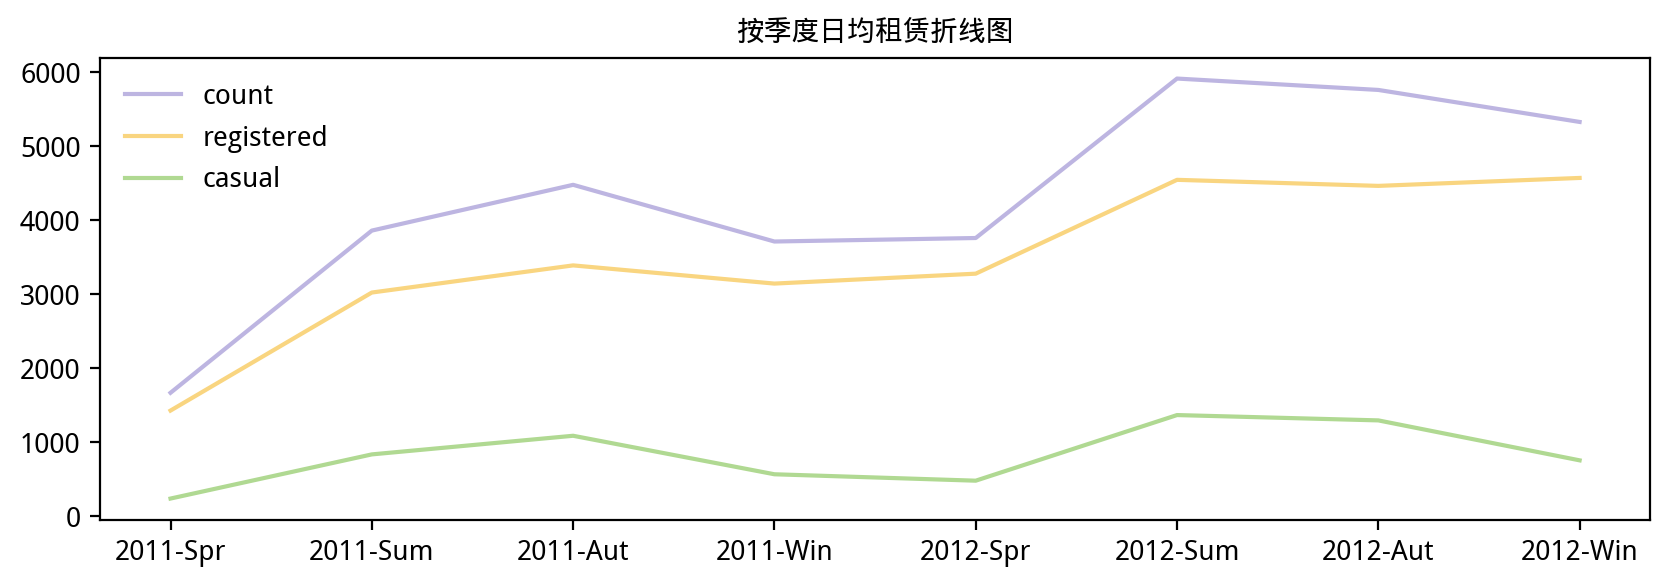

In [32]:
# 作折线图
plt.figure(figsize=(10,3),dpi=200)
plt.plot(df_temp['season1'],df_temp['count'],label = 'count',color = '#bdb5e1')
plt.plot(df_temp['season1'],df_temp['registered'],label = 'registered',color = '#f9d580')
plt.plot(df_temp['season1'],df_temp['casual'],label = 'casual',color = '#b0d992')
plt.title('按季度日均租赁折线图')
plt.legend(loc = 2,frameon=False)
plt.show()
# 小结：
# 1）和月度日均租赁量的结果类似，春夏秋 是租赁量的高峰期，且与是否注册无关；
# 2）从具体数值查询可知，夏季 为租赁量最高者；
# 3）按年度看，租赁量逐步稳步上升；

In [33]:
# 5、按工作日与否，观测日均租赁量
# 主要是工作日、非工作日的日均租赁量水平；
df_temp = df_train.groupby(['workingday','date1'])[['count','registered','casual']].sum().reset_index()
df_workingday = df_temp.groupby(['workingday'])[['count','registered','casual']].mean().reset_index()
# 将x轴上，工作日与否的数值，改为文本标签：
df_workingday['type'] = df_workingday.apply(lambda x:'工作日' if x['workingday'] ==1 else '非工作日',axis=1)

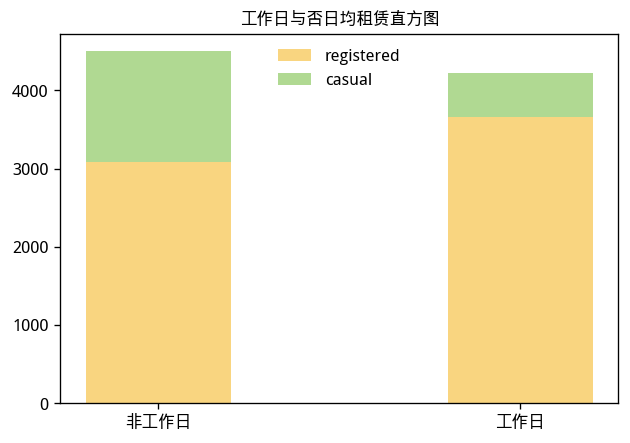

In [34]:
# 做堆叠直方图
# 由于 count列，为registered、casual的和，因此堆叠图中，y列放2个变量即可；
x1 = df_workingday['type']
y1 = df_workingday['registered']
y2 = df_workingday['casual']
plt.figure(figsize=(6,4),dpi=120)
plt.bar(x1,y1,label ='registered',color = '#f9d580',width=0.4)
plt.bar(x1,y2,label = 'casual',color = '#b0d992',bottom=y1,width=0.4)
plt.title('工作日与否日均租赁直方图')
plt.legend(loc = ('upper center'),frameon=False)
plt.show()

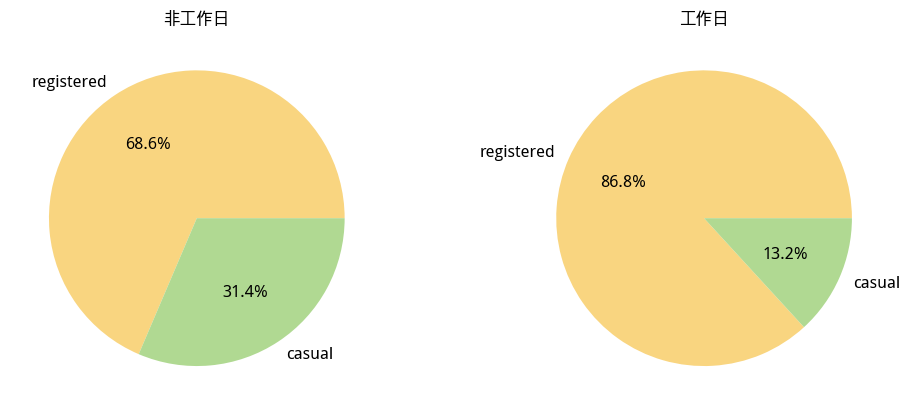

In [35]:
# 作饼图
# 由于堆叠图，有时不甚明显，可进一步通过饼图来观测；
# 注册与否用户在是否工作日下所占比例；
df_workingday_y = np.array(df_workingday.query('workingday == 1')[['registered','casual']]).reshape(-1)
df_workingday_n = np.array(df_workingday.query('workingday == 0')[['registered','casual']]).reshape(-1)
plt.figure(figsize=(10,4),dpi=120)
plt.subplot(1,2,1)
plt.pie(df_workingday_n,labels = ['registered','casual'],colors = ['#f9d580','#b0d992'],autopct='%1.1f%%')
plt.title('非工作日')
plt.subplot(1,2,2)
plt.pie(df_workingday_y,labels = ['registered','casual'],colors = ['#f9d580','#b0d992'],autopct='%1.1f%%')
plt.title('工作日')
plt.show()
# 小结：
# 1）通过是否注册用户在工作日与否的租赁量详细占比可见，非工作日中非注册用户的租赁量占比明显高于工作日；
# 2）即，非工作日，会面临更多随机租赁的用户群体；

In [36]:
# 6、按一周来看，周一到周日日均租赁量
df_temp = df_train.groupby(['weekday2','weekday1','date1'])[['count','registered','casual']].sum().reset_index()
df_weekday = df_temp.groupby(['weekday2','weekday1'])[['count','registered','casual']].mean().reset_index()
# 为了将图形按周一到周日顺序展现，可提前排序；
df_weekday.sort_values('weekday1',inplace=True)
df_weekday.reset_index(drop = True,inplace=True)
# 和上述工作日的堆叠直方图类似，提前选定x轴、y轴；
# x轴，以星期的完整名显示；
x1 = df_weekday['weekday2']
y1 = df_weekday['registered']
y2 = df_weekday['casual']

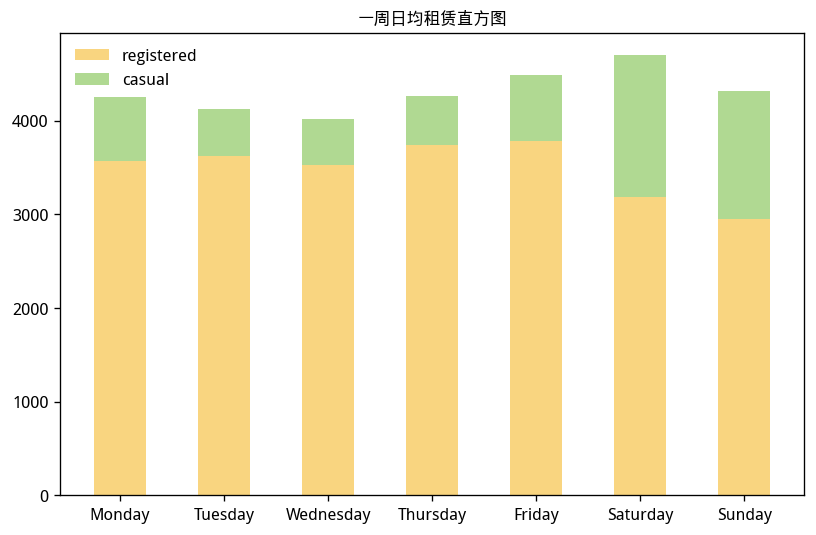

In [37]:
# 作堆叠直方图
# 按星期作日均租赁量堆叠直方图
plt.figure(figsize=(8,5),dpi=120)
plt.bar(x1,y1,label ='registered',color = '#f9d580',width=0.5)
plt.bar(x1,y2,label = 'casual',color = '#b0d992',width=0.5,bottom=y1)
plt.title('一周日均租赁直方图')
plt.legend(loc = 2,frameon=False)
plt.show()
# 小结：
# 1）一周内，周六、周五、周日租赁量最高；
# 2）周六租赁量平均水平最高，且非注册用户租赁量最高，符合用户使用习惯；

In [38]:
# 7、按节假日与否，观测日均租赁量
df_temp = df_train.groupby(['holiday','date1'])[['count','registered','casual']].sum().reset_index()
df_holiday = df_temp.groupby(['holiday'])[['count','registered','casual']].mean().reset_index()
# 将x轴以文字显示：
df_holiday['holiday'] = df_holiday.apply(lambda x:'节假日' if x['holiday'] == 1 else '非节假日',axis = 1)
x1 = df_holiday['holiday']
y1 = df_holiday['registered']
y2 = df_holiday['casual']

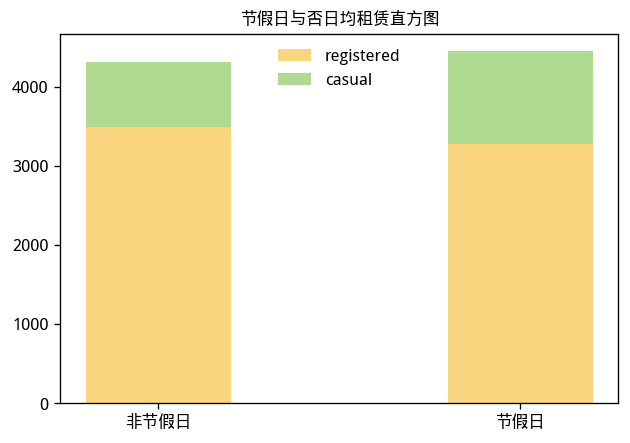

In [39]:
# 作堆叠直方图
# 作按节假日与否，观测日均租赁量堆叠直方图
plt.figure(figsize=(6,4),dpi=120)
plt.bar(x1,y1,label ='registered',color = '#f9d580',width=0.4)
plt.bar(x1,y2,label = 'casual',color = '#b0d992',bottom=y1,width=0.4)
plt.title('节假日与否日均租赁直方图')
plt.legend(loc = 'upper center',frameon=False)
plt.show()
# 小结：
# 1）两者几乎持平，节假日租赁量水平略微高于非假日；
# 2）符合实际生活中，大家出游需求；

In [40]:
# 3-8-2 环境角度
# 1、从天气情况预测
# 看下具体数据，即，同一天中，各时刻所记录的weather是否相同；
a = df_train[['date1','weather']].drop_duplicates()
b = a.groupby('date1')['weather'].count().reset_index()
b.columns = ['date1','weather_cnt']
# 查询可知，同一天存在不同的天气记录；
print(b.query('weather_cnt != 1'))

         date1  weather_cnt
0   2011-01-01            3
1   2011-01-02            3
3   2011-01-04            2
5   2011-01-06            2
6   2011-01-07            3
..         ...          ...
449 2012-12-13            2
451 2012-12-15            2
452 2012-12-16            3
453 2012-12-17            2
454 2012-12-18            3

[351 rows x 2 columns]


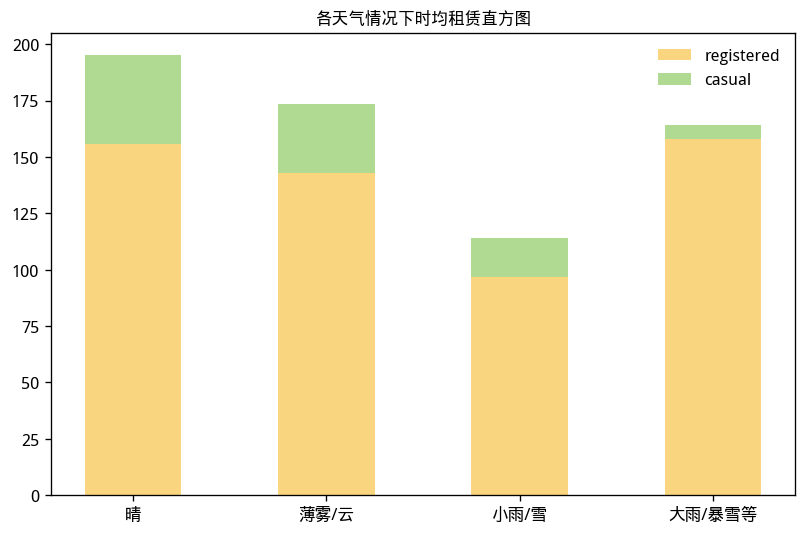

In [41]:
# 作堆叠直方图
# 由于同一天，天气均有可能存在不同记录；
# 因此需直接计算各天气状况下，每小时租赁量平均水平，而不是按日均；
df_weather = df_train.groupby('weather')[['count','registered','casual']].mean().reset_index()
# 最好将x轴的天气数值换成文字形式；
# weather：天气概况；1：晴、少云等，2：薄雾+云，3：小雨小雪，4：大雨雷暴大雪等；
df_weather['weather'] = df_weather.apply(lambda x:'晴' if x['weather'] == 1 \
    else '薄雾/云' if x['weather'] == 2 else '小雨/雪' if x['weather'] == 3 else '大雨/暴雪等',axis = 1)
x1 = df_weather['weather']
y1 = df_weather['registered']
y2 = df_weather['casual']
plt.figure(figsize=(8,5),dpi=120)
plt.bar(x1,y1,label = 'registered',color = '#f9d580',width =0.5)
plt.bar(x1,y2,label = 'casual',color = '#b0d992',width =0.5,bottom=y1)
plt.title('各天气情况下时均租赁直方图')
plt.legend(loc = 1,frameon=False)
plt.show()
# 小结：一般情况下，均符合日常使用习惯，即，天气越好，平均租赁量水平越高；

In [42]:
# 该图，出现一个异常点，天气为4的情况，是天气极其恶劣的状况，但其租赁量水平突增；
# 因此，需查看具体数据；
# 查询后可知，天气为4的恶劣数据，仅1条；
# 即，该条数据的租赁量就是该天气的平均租赁量；
print(df_train.query('weather == 4'))
# 观测该条数据，会发现，本次租赁，发生在工作日，晚上6点，本就处于晚高峰(最需要用车的时刻)；
# 且，体感温度在11度左右，适宜用车；
# 也就可以解释，为什么单条数据拉高了该层级整个的平均水平；
# 其他天气状况下，均符合日常使用习惯，即，天气越好，平均租赁量水平越高；

                 datetime  season  holiday  workingday  weather  temp   atemp  \
5631  2012-01-09 18:00:00       1        0           1        4   8.2  11.365   

      humidity  windspeed  casual  registered  count                 dt1  \
5631        86     6.0032     6.0       158.0  164.0 2012-01-09 18:00:00   

      year1  month1      date1  weekday1 weekday2  hour1  
5631   2012       1 2012-01-09         0   Monday     18  


In [43]:
# 2、从气温情况观测
# 首先，通过对一天中不同温度下的数量统计，可知，该特征在同一天也会随着时间而变化；
df_temp = df_train[['date1','temp']].drop_duplicates()
a = df_temp.groupby('date1')['temp'].count().reset_index()
a.columns = ['date1','temp_cnt']
# 下列数据，也可说明，x轴上的temp数据，为连续变量，非分类变量；
print(a.query('temp_cnt != 1'))

         date1  temp_cnt
0   2011-01-01        10
1   2011-01-02        12
2   2011-01-03         7
3   2011-01-04         9
4   2011-01-05         8
..         ...       ...
451 2012-12-15         9
452 2012-12-16         4
453 2012-12-17         4
454 2012-12-18         9
455 2012-12-19        10

[455 rows x 2 columns]


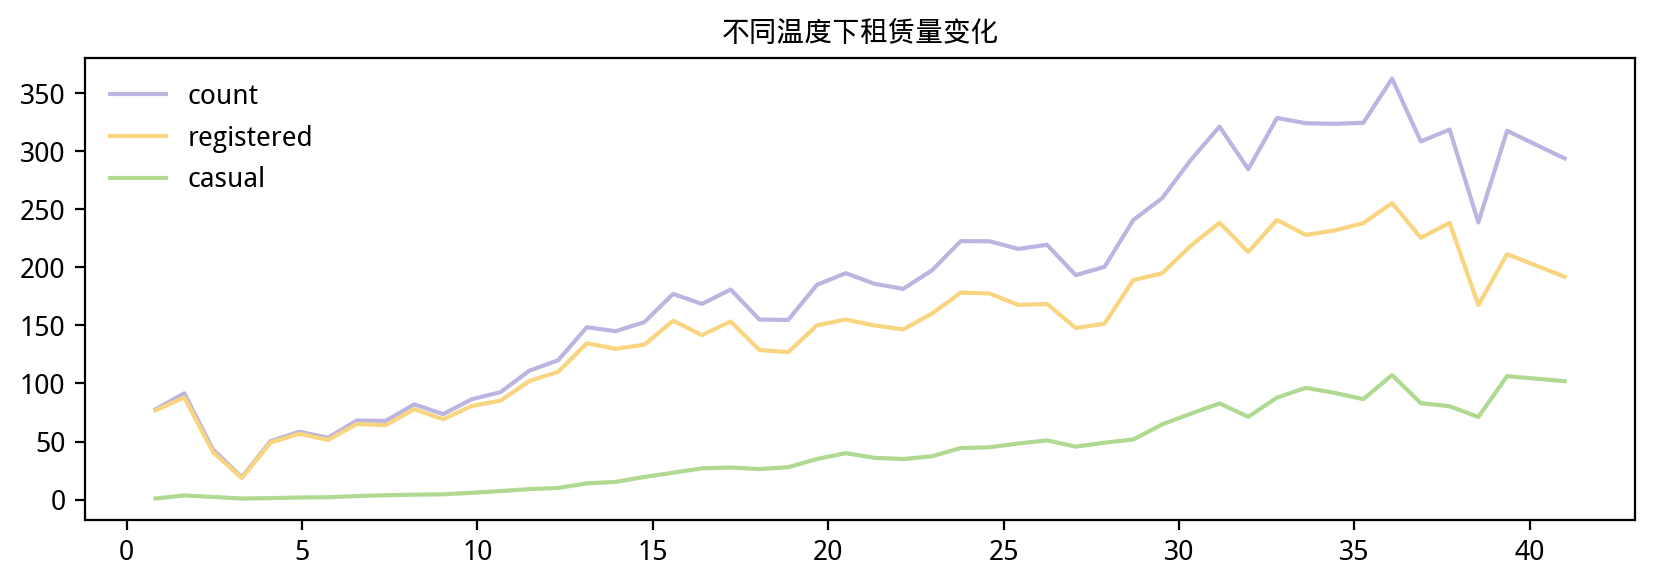

In [44]:
# 作折线图
# 直接用时间段作折线图,以观测温度与租赁量的关系；
df_temp = df_train.groupby('temp')[['count','registered','casual']].mean()
plt.figure(figsize=(10,3),dpi=200)
plt.plot(df_temp['count'],label = 'count',color = '#bdb5e1')
plt.plot(df_temp['registered'],label ='registered',color = '#f9d580')
plt.plot(df_temp['casual'],label = 'casual',color = '#b0d992')
plt.legend(loc = 2,frameon=False)
plt.title('不同温度下租赁量变化')
plt.show()
# 小结：
# 1）通过上图可见，与月份、季节一致，春夏秋的温度是最适宜租赁的；
# 2）温度太高、太低，都会降低租赁量；
# 3）因此，随着温度上升，租赁量水平逐步到达高峰期，温度过高后，也会降低；

In [45]:
# 3、从体感温度观测
# 看是否与实际温度规律一致；
# 与温度类似，本次案例记录的体感温度也是连续变量；
# 即，同一天，体感温度随着时刻不同而变化；
df_temp = df_train[['date1','atemp']].drop_duplicates()
a = df_temp.groupby('date1')['atemp'].count().reset_index()
a.columns = ['date1','atemp_cnt']
# 下列数据，也可说明，x轴上的atemp数据，为连续变量，非分类变量；
print(a.query('atemp_cnt != 1'))

         date1  atemp_cnt
0   2011-01-01         10
1   2011-01-02         11
2   2011-01-03         11
3   2011-01-04          8
4   2011-01-05          7
..         ...        ...
451 2012-12-15         10
452 2012-12-16          6
453 2012-12-17          5
454 2012-12-18          9
455 2012-12-19         11

[454 rows x 2 columns]


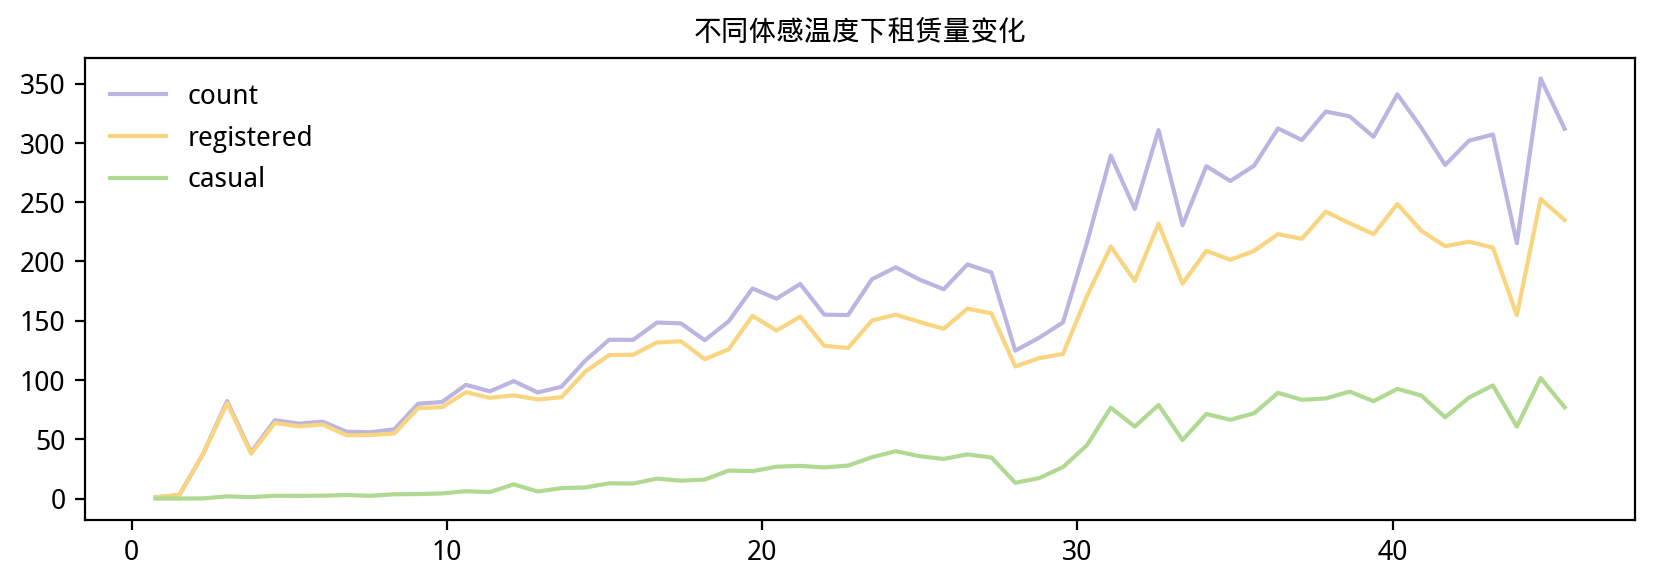

In [46]:
# 作折线图
# 直接用时间段作折线图
df_temp = df_train.groupby('atemp')[['count','registered','casual']].mean()
plt.figure(figsize=(10,3),dpi=200)
plt.plot(df_temp['count'],label = 'count',color = '#bdb5e1')
plt.plot(df_temp['registered'],label ='registered',color = '#f9d580')
plt.plot(df_temp['casual'],label = 'casual',color = '#b0d992')
plt.legend(loc = 2,frameon=False)
plt.title('不同体感温度下租赁量变化')
plt.show()
# 小结：
# 验证后，可知，与上述，实际温度与租赁量的规律基本一致；
# 另一方面，进一步说明，两者相关性较高；
# 在之后的模型构建、特征选择上，实际温度/体感温度仅可选1个；

In [47]:
# 4、从湿度情况观测
df_temp = df_train[['date1','humidity']].drop_duplicates()
a = df_temp.groupby('date1')['humidity'].count().reset_index()
a.columns = ['date1','humidity_cnt']
# 下列数据，也可说明，x轴上的humidity数据，为连续变量，非分类变量；
print(a.query('humidity_cnt != 1'))

         date1  humidity_cnt
0   2011-01-01            11
1   2011-01-02            14
2   2011-01-03            11
3   2011-01-04            12
4   2011-01-05            13
..         ...           ...
451 2012-12-15            11
452 2012-12-16             5
453 2012-12-17             5
454 2012-12-18            15
455 2012-12-19             9

[455 rows x 2 columns]


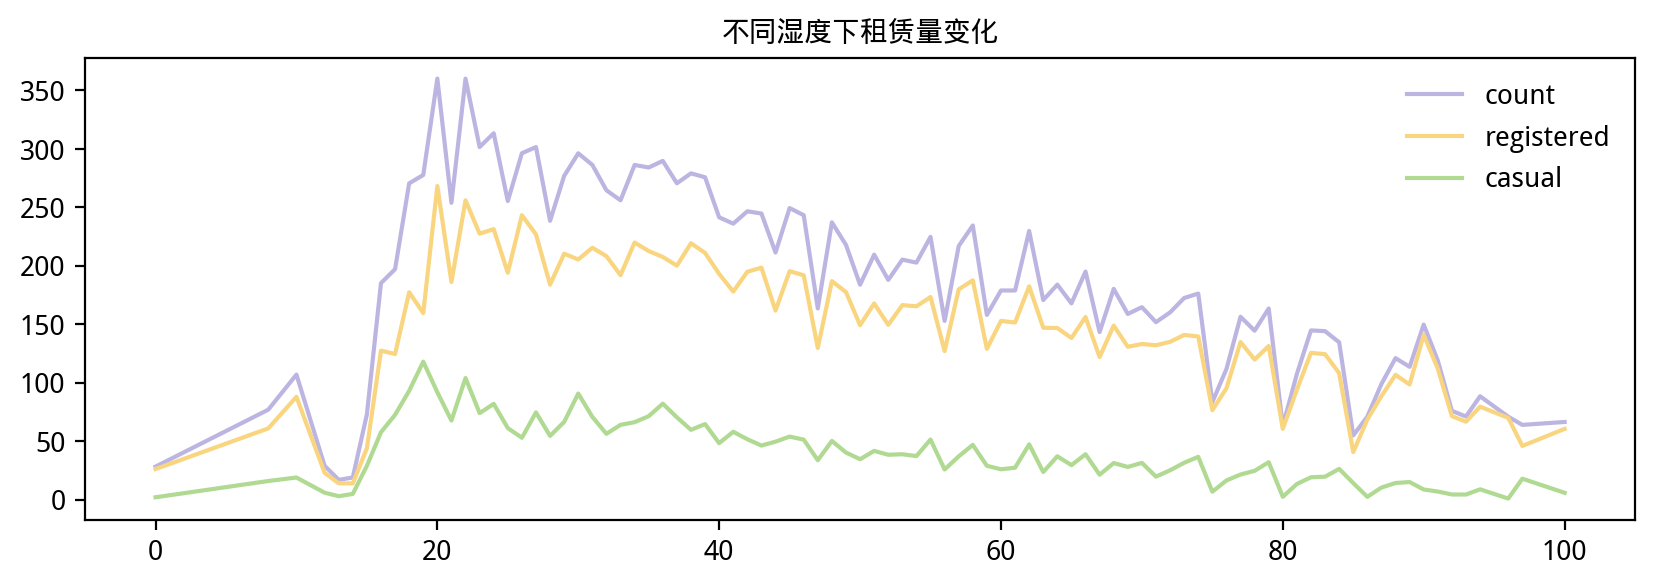

In [48]:
# 作折线图；
# 上述可知，湿度也是连续变量，直接用时刻观测即可；
df_temp = df_train.groupby('humidity')[['count','registered','casual']].mean()
plt.figure(figsize=(10,3),dpi=200)
plt.plot(df_temp['count'],label = 'count',color = '#bdb5e1')
plt.plot(df_temp['registered'],label ='registered',color = '#f9d580')
plt.plot(df_temp['casual'],label = 'casual',color = '#b0d992')
plt.legend(loc = 1,frameon=False)
plt.title('不同湿度下租赁量变化')
plt.show()
# 小结：
# 1）湿度约为20时，租赁量最高；
# 2）湿度更高时，只会下降；
# 3）这也符合，雨雪天，湿度更高，只会降低租赁量的情况；

In [49]:
# 5、从风速情况观测
df_temp = df_train[['date1','windspeed']].drop_duplicates()
a = df_temp.groupby('date1')['windspeed'].count().reset_index()
a.columns = ['date1','windspeed_cnt']
# 下列数据，也可说明，x轴上的windspeed数据，为连续变量，非分类变量；
print(a.query('windspeed_cnt != 1'))

         date1  windspeed_cnt
0   2011-01-01             11
1   2011-01-02             10
2   2011-01-03             12
3   2011-01-04             10
4   2011-01-05             10
..         ...            ...
451 2012-12-15             13
452 2012-12-16              8
453 2012-12-17             11
454 2012-12-18             14
455 2012-12-19              9

[456 rows x 2 columns]


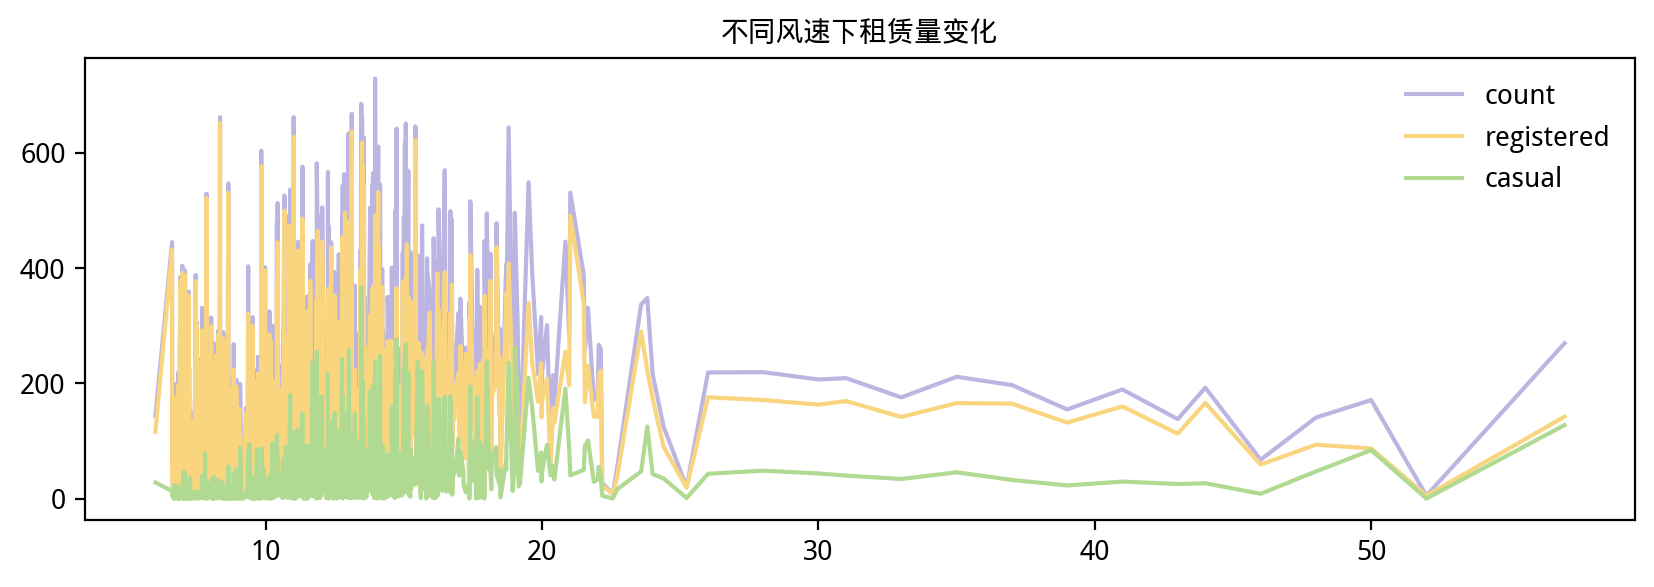

In [50]:
# 作折线图
# 上述可知，风速也是连续变量，直接用时刻观测即可；
df_temp = df_train.groupby('windspeed')[['count','registered','casual']].mean()
plt.figure(figsize=(10,3),dpi=200)
plt.plot(df_temp['count'],label = 'count',color = '#bdb5e1')
plt.plot(df_temp['registered'],label ='registered',color = '#f9d580')
plt.plot(df_temp['casual'],label = 'casual',color = '#b0d992')
plt.legend(loc = 'upper right',frameon=False)
plt.title('不同风速下租赁量变化')
plt.show()
# 小结：
# 1）图形未出现明显线性变化，而是呈现巨幅的上下波动；
# 2）主要原因在于，我们对原来可能缺失的值，进行了填充，导致数据过于密集；
# 3）每组的数据太少，导致波动忽上忽下；
# 4）后面风速逐渐增加后，尤其是大于30后，租赁量开始下降；
# 5）但是在40的过后却有反弹；

In [51]:
# 详见下这条异常数据
print(df_train[(df_train['windspeed'] > 40) & (df_train['count'] > 400)])
# 可见，这条被提取的数据，其实是发生在晚上的高峰期 17:00，也符合情况；

                 datetime  season  holiday  workingday  weather   temp  atemp  \
6515  2012-03-08 17:00:00       1        0           1        1  25.42  31.06   

      humidity  windspeed  casual  registered  count                 dt1  \
6515        38    43.9989    52.0       545.0  597.0 2012-03-08 17:00:00   

      year1  month1      date1  weekday1  weekday2  hour1  
6515   2012       3 2012-03-08         3  Thursday     17  


In [52]:
# 3-9 特征选择
# 3-9-1、相关性分析
# 为了通过相关性强的特征来预测结果，进行特征选择，并先进行相关性分析；
# corr 方法中，pearson检验为默认，同时附上 spearman、kendall的比较；
# 为了只分析相关强度，对可能呈现负相关的，先取绝对值；
# 重点观测与 总租赁量相关性极高的特征即可：
df_columns = ['count','registered','casual','hour1','temp','atemp','humidity',\
              'year1','month1','season','weather','windspeed','weekday1','workingday','holiday']
df_corr1 = np.abs(df_train[df_columns].corr())[['count']]
df_corr1.columns = ['count_pearson']
df_corr2 = np.abs(df_train[df_columns].corr(method = 'spearman'))[['count']]
df_corr2.columns = ['count_spearman']
df_corr3 = np.abs(df_train[df_columns].corr(method = 'kendall'))[['count']]
df_corr3.columns = ['count_kendall']
df_corr = pd.concat([df_corr1,df_corr2,df_corr3],axis=1)
df_corr.sort_values(by = 'count_pearson',ascending = False,inplace = True)
print(df_corr)

            count_pearson  count_spearman  count_kendall
count            1.000000        1.000000       1.000000
registered       0.966209        0.988446       0.917271
casual           0.704764        0.844619       0.664297
hour1            0.405437        0.515701       0.338069
temp             0.385954        0.396949       0.272857
atemp            0.381967        0.395622       0.270547
humidity         0.317028        0.348875       0.236046
year1            0.234959        0.201716       0.164979
month1           0.164673        0.177086       0.121863
season           0.159801        0.172391       0.127211
weather          0.127519        0.110619       0.088327
windspeed        0.111656        0.153739       0.105485
weekday1         0.022602        0.025172       0.018236
workingday       0.020764        0.015754       0.012885
holiday          0.002978        0.002426       0.001984


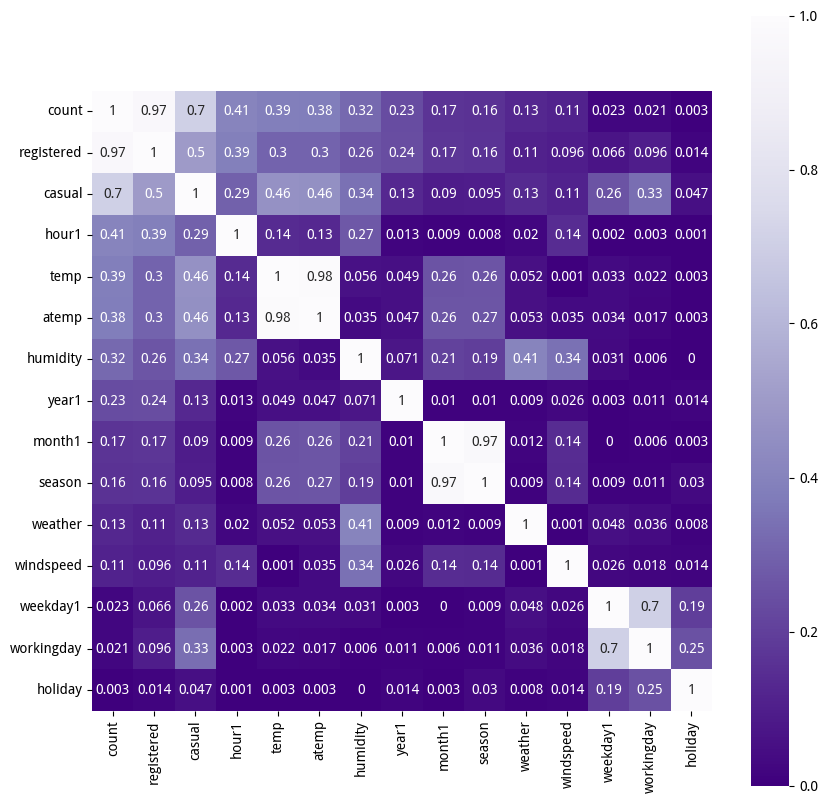

In [53]:
# 作热力图
# 以此观测相关性
df_corr = np.round(np.abs(df_train[df_columns].corr()),3)
plt.figure(figsize=(10,10),dpi=100)
# cmap 来配置颜色
sns.heatmap(df_corr,cmap = 'Purples_r',square=True,annot=True,cbar=True)
plt.show()
# 小结：
# 1）以上是把train表中，数值型的特征和结果项做了相关性分析与展示；
# 2）图中可见，相关性越强的，颜色越浅；
# 3）且，为了只分析相关强度，对可能呈现负相关的，取绝对值；

In [54]:
# 3-9-2、选择特征
# 选择 hour1、temp、humidity、year1、month1、season、weather、windspeed、weekday1、workingday、holiday作为特征项；

In [55]:
# 对于类别特征（即，非连续、离散、无序的多分类特征）,低基数：
# 即，year、season、weather，使用 one-hot 转化成二分型数据；

# 由于get_dummies函数只能处理字符串类型的分类变量；
# 所以，若拟处理的分类变量不是字符串类型，需先将其转换为字符串类型，再处理；
# prefix 为处理后分类变量的前缀；
df_one_hot = pd.get_dummies(df_whole[['year1','season','weather']].astype('str'),prefix=['Year','Season','Weather'])
# 将处理后的分类数据，与原整体数据，按轴连接起来；
df_whole = pd.concat([df_whole,df_one_hot],axis = 1)

In [56]:
# 数据规范化：Z-Score 规范化，使得特征符合，均值为0，方差为1的分布
scaler1 = preprocessing.StandardScaler()
df_whole['temp_scaler'] = scaler1.fit_transform(df_whole[['temp']])
df_whole['humidity_scaler'] = scaler1.fit_transform(df_whole[['humidity']])
df_whole['windspeed_scaler'] = scaler1.fit_transform(df_whole[['windspeed']])

In [57]:
# 提取训练集、测试集
# 由于将采用网格搜索、K折交叉验证的方式调参，评估模型；
# 且将通过提交最后测试结果，评测最终得分；
# 因此，本项目，不进一步将训练集划分出验证集；
df_columns = ['season','weather','dt1','temp','humidity','windspeed','atemp','date1','year1','datetime','weekday2','count','registered','casual']
df_test = df_whole[df_whole['count'].isna()].reset_index(drop=True)
df_train = df_whole[df_whole['count'].notna()].reset_index(drop=True)
df_train_y = np.log1p(df_train['count'])
df_train_x = df_train.drop(df_columns,axis = 1)
df_test_sj = df_test['datetime']
df_test_x = df_test.drop(df_columns,axis = 1)

In [58]:
# 由于拟预测的 count租赁总量，可直接预测；
# 或先预测 registered、casual的结果，叠加后得到总体预测结果；
# 本项目，拟采用上述两种方式，以进行模型训练；
# 因此，还需提前提取 registered、casual数据；

# registered 数据，作 log1p变换
df_train_r_y = np.log1p(df_train['registered'])
# casual 数据，作 log1p变换
df_train_c_y = np.log1p(df_train['casual'])

In [59]:
# 四、构建、训练、评估模型
# 4-1 构建模型
# 本项目拟尝试多种回归模型，
# 附之网格调参，K折交叉验证，来构建、训练模型；

# 1、岭回归--Ridge模型
# 1）直接用 count 来预测
# 网格搜索调参，构建模型；
# param1 = {'alpha':[0.1,1,2,3,4,10,20,30,40,100,200,300,400]}
# model1 = GridSearchCV(estimator=Ridge(random_state = 10),param_grid=param1,\
#                       scoring='r2',cv=5) # 5折交叉验证
# model1.fit(df_train_x,df_train_y)
# print(model1.best_score_) # 最佳得分，r2系数为 0.43438665219355493，模型预估不是很适合
# print(model1.best_params_) # 最佳参数，{'alpha': 300}

In [60]:
# 训练模型
# 将最优参数运用到模型中
model1_Ridge = Ridge(random_state = 10,alpha=300)
model1_Ridge.fit(df_train_x,df_train_y)

Ridge(alpha=300, random_state=10)

In [61]:
# 产生预测结果
# 此模型最终提交后，kaggle平台得分，1.02676
df_test_y = model1_Ridge.predict(df_test_x)
df_test['predict_model1_Ridge'] = np.expm1(df_test_y)

In [62]:
# 2）用 registered、casual，分开来预测
# 网格搜索调参，构建模型；
# registered 部分
# param1_r = {'alpha':[0.1,1,2,3,4,10,20,30,40,100,200,300,400]}
# model1_r = GridSearchCV(estimator=Ridge(random_state = 10),param_grid=param1_r,\
#                         scoring='r2',cv=5)
# model1_r.fit(df_train_x,df_train_r_y)
# print(model1_r.best_score_) # 最佳得分，r2系数为 0.4115489493669031，模型预估不是很适合
# print(model1_r.best_params_) # 最佳参数，{'alpha': 200}

In [63]:
# casual 部分
# param1_c = {'alpha':[0.1,1,2,3,4,10,20,30,40,100,200,300,400]}
# model1_c = GridSearchCV(estimator=Ridge(random_state = 10),param_grid=param1_c,\
#                         scoring='r2',cv=5)
# model1_c.fit(df_train_x,df_train_c_y)
# print(model1_c.best_score_) # 最佳得分，r2系数为 0.5393137449056173，模型预估不是很适合
# print(model1_c.best_params_) # 最佳参数，{'alpha': 200}

In [64]:
# 训练模型
# 将最优参数运用到模型中
# registered 部分
model2_Ridge_r = Ridge(random_state = 10,alpha=200)
model2_Ridge_r.fit(df_train_x,df_train_r_y)

# casual 部分
model2_Ridge_c = Ridge(random_state = 10,alpha=200)
model2_Ridge_c.fit(df_train_x,df_train_c_y)

Ridge(alpha=200, random_state=10)

In [65]:
# 产生预测结果
# 此模型最终提交后，kaggle平台得分，1.02571
# 即，在 Ridge模型中，将 count分为 registered + casual来预测更恰当
# registered 部分
df_test_r_y = np.expm1(model2_Ridge_r.predict(df_test_x))
# casual 部分
df_test_c_y = np.expm1(model2_Ridge_c.predict(df_test_x))
# 整体
df_test['predict_model2_Ridge'] = df_test_r_y + df_test_c_y

In [66]:
# 2、Lasso模型
# 1）直接用 count 来预测
# param1 = {'alpha':[0.1,1,2,3,4,10,20,30,40,100,200,300,400]}
# model1 = GridSearchCV(estimator=Lasso(random_state = 10),param_grid=param1,\
#                       scoring='r2',cv=5)
# model1.fit(df_train_x,df_train_y)
# print(model1.best_score_) # 最佳得分，r2系数为 0.33784865378576234，模型预估不是很适合
# print(model1.best_params_) # 最佳参数，{'alpha': 0.1}

In [67]:
# 训练模型
# 将最优参数运用到模型中
model1_Lasso = Lasso(random_state = 10,alpha=0.1)
model1_Lasso.fit(df_train_x,df_train_y)

Lasso(alpha=0.1, random_state=10)

In [68]:
# 产生预测结果
# 此模型最终提交后，kaggle平台得分，1.06820
df_test_y = model1_Lasso.predict(df_test_x)
df_test['predict_model1_Lasso'] = np.expm1(df_test_y)

In [69]:
# 2）用 registered、casual，分开来预测
# 网格搜索调参，构建模型；
# registered 部分
# param1_r = {'alpha':[0.1,1,2,3,4,10,20,30,40,100,200,300,400]}
# model1_r = GridSearchCV(estimator=Lasso(random_state = 10),param_grid=param1_r,\
#                       scoring='r2',cv=5)
# model1_r.fit(df_train_x,df_train_r_y)
# print(model1_r.best_score_) # 最佳得分，r2系数为 0.3049244444641319，模型预估不是很适合
# print(model1_r.best_params_) # 最佳参数，{'alpha': 0.1}

In [70]:
# casual 部分
# param1_c = {'alpha':[0.1,1,2,3,4,10,20,30,40,100,200,300,400]}
# model1_c = GridSearchCV(estimator=Lasso(random_state = 10),param_grid=param1_c,\
#                       scoring='r2',cv=5)
# model1_c.fit(df_train_x,df_train_c_y)
# print(model1_c.best_score_) # 最佳得分，r2系数为 0.4629729975638813，模型预估不是很适合
# print(model1_c.best_params_) # 最佳参数，{'alpha': 0.1}

In [71]:
# 训练模型
# 将最优参数运用到模型中
# registered 部分
model2_Lasso_r = Lasso(random_state = 10,alpha=0.1)
model2_Lasso_r.fit(df_train_x,df_train_r_y)

# casual 部分
model2_Lasso_c = Lasso(random_state = 10,alpha=0.1)
model2_Lasso_c.fit(df_train_x,df_train_c_y)

Lasso(alpha=0.1, random_state=10)

In [72]:
# 产生预测结果
# 此模型最终提交后，kaggle平台得分，1.06743
# 即，在 Lasso模型中，将 count分为 registered + casual来预测更恰当
# registered 部分
df_test_r_y = np.expm1(model2_Lasso_r.predict(df_test_x))
# casual 部分
df_test_c_y = np.expm1(model2_Lasso_c.predict(df_test_x))
# 整体
df_test['predict_model2_Lasso'] = df_test_r_y + df_test_c_y

In [73]:
# 3、Knn模型
# 1）直接用 count 来预测
# param1 = {'n_neighbors':range(5,101)}
# model1 = GridSearchCV(estimator=KNeighborsRegressor(),\
#                       param_grid=param1,scoring='r2',cv=5) # 5折交叉验证
# model1.fit(df_train_x,df_train_y)
# print(model1.best_score_) # 最佳得分，r2系数为 0.810245877031621，超过 80%，模型还可以
# print(model1.best_params_) # 最佳参数，{'n_neighbors': 12}

In [74]:
# param2 = {'leaf_size':range(30,101)}
# model2 = GridSearchCV(estimator=KNeighborsRegressor(n_neighbors=12),\
#                       param_grid=param2,scoring='r2',cv=5) # 5折交叉验证
# model2.fit(df_train_x,df_train_y)
# print(model2.best_score_) # 最佳得分，r2系数为 0.810245877031621,超过 80%，模型还可以
# print(model2.best_params_) # 最佳参数，{'leaf_size': 30}

In [75]:
# 训练模型
# 将最优参数运用到模型中
model1_Knn = KNeighborsRegressor(n_neighbors=12,leaf_size=30)
model1_Knn.fit(df_train_x,df_train_y)

KNeighborsRegressor(n_neighbors=12)

In [76]:
# 产生预测结果
# 此模型最终提交后，kaggle平台得分，0.50647
df_test_y = model1_Knn.predict(df_test_x)
df_test['predict_model1_Knn'] = np.expm1(df_test_y)

In [77]:
# 2）用 registered、casual，分开来预测
# 网格搜索调参，构建模型；
# registered 部分
# param1_r = {'n_neighbors':range(5,101)}
# model1_r = GridSearchCV(estimator=KNeighborsRegressor(),\
#                       param_grid=param1_r,scoring='r2',cv=5) # 5折交叉验证
# model1_r.fit(df_train_x,df_train_r_y)
# print(model1_r.best_score_) # 最佳得分，r2系数为 0.8018232424482399，超过 80%，模型还可以
# print(model1_r.best_params_) # 最佳参数，{'n_neighbors':12}

In [78]:
# param2_r = {'leaf_size':range(30,101)}
# model2_r = GridSearchCV(estimator=KNeighborsRegressor(n_neighbors=12),\
#                       param_grid=param2_r,scoring='r2',cv=5) # 5折交叉验证
# model2_r.fit(df_train_x,df_train_r_y)
# print(model2_r.best_score_) # 最佳得分，r2系数为 0.8018232424482399，超过 80%，模型还可以
# print(model2_r.best_params_) # 最佳参数，{'leaf_size':30}

In [79]:
# casual 部分
# param1_c = {'n_neighbors':range(5,101)}
# model1_c = GridSearchCV(estimator=KNeighborsRegressor(),\
#                       param_grid=param1_c,scoring='r2',cv=5) # 5折交叉验证
# model1_c.fit(df_train_x,df_train_c_y)
# print(model1_c.best_score_) # 最佳得分，r2系数为 0.74915573251523
# print(model1_c.best_params_) # 最佳参数，{'n_neighbors':20}

In [80]:
# param2_c = {'leaf_size':range(30,101)}
# model2_c = GridSearchCV(estimator=KNeighborsRegressor(n_neighbors=20),\
#                       param_grid=param2_c,scoring='r2',cv=5) # 5折交叉验证
# model2_c.fit(df_train_x,df_train_c_y)
# print(model2_c.best_score_) # 最佳得分，r2系数为 0.74915573251523
# print(model2_c.best_params_) # 最佳参数，{'leaf_size': 30}

In [81]:
# 训练模型
# 将最优参数运用到模型中
# registered 部分
model2_Knn_r = KNeighborsRegressor(n_neighbors=12,leaf_size=30)
model2_Knn_r.fit(df_train_x,df_train_r_y)

# casual 部分
model2_Knn_c = KNeighborsRegressor(n_neighbors=20,leaf_size=30)
model2_Knn_c.fit(df_train_x,df_train_c_y)

KNeighborsRegressor(n_neighbors=20)

In [82]:
# 产生预测结果
# 此模型最终提交后，kaggle平台得分，0.50405
# 即，在 Knn模型中，将 count分为 registered + casual来预测更恰当
# registered 部分
df_test_r_y = np.expm1(model2_Knn_r.predict(df_test_x))
# casual 部分
df_test_c_y = np.expm1(model2_Knn_c.predict(df_test_x))
# 整体
df_test['predict_model2_Knn'] = df_test_r_y + df_test_c_y

In [83]:
# 4、AdaBoostRegressor模型
# 1）直接用 count 来预测
# 网格搜索调参，构建模型；
# param1 = {'n_estimators':range(500,1001,100)}
# model1 = GridSearchCV(estimator=AdaBoostRegressor(random_state=10),\
#                       param_grid=param1,scoring='r2',cv=5) # 5折交叉验证
# model1.fit(df_train_x,df_train_y)
# print(model1.best_score_) # 最佳得分，r2系数为 0.7228197063260646
# print(model1.best_params_) # 最佳参数，{'n_estimators':500}

In [84]:
# param2 = {'learning_rate':[0.00001,0.00005,0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1,3,5,10]}
# model2 = GridSearchCV(estimator=AdaBoostRegressor(random_state=10,n_estimators=500),\
#                       param_grid=param2,scoring='r2',cv=5) # 5折交叉验证
# model2.fit(df_train_x,df_train_y)
# print(model2.best_score_) # 最佳得分，r2系数为 0.7803860899671647
# print(model2.best_params_) # 最佳参数，{'learning_rate':3}

In [85]:
# 训练模型
# 将最优参数运用到模型中
model1_AdaBoostRegressor = AdaBoostRegressor(random_state = 10,n_estimators=500,learning_rate=3)
model1_AdaBoostRegressor.fit(df_train_x,df_train_y)

AdaBoostRegressor(learning_rate=3, n_estimators=500, random_state=10)

In [86]:
# 产生预测结果
# 此模型最终提交后，kaggle平台得分，0.68220
df_test_y = model1_AdaBoostRegressor.predict(df_test_x)
df_test['predict_model1_AdaBoostRegressor'] = np.expm1(df_test_y)

In [87]:
# 2）用 registered、casual，分开来预测
# 网格搜索调参，构建模型；
# registered 部分
# param1_r = {'n_estimators':range(500,1001,100)}
# model1_r = GridSearchCV(estimator=AdaBoostRegressor(random_state=10),\
#                       param_grid=param1_r,scoring='r2',cv=5) # 5折交叉验证
# model1_r.fit(df_train_x,df_train_r_y)
# print(model1_r.best_score_) # 最佳得分，r2系数为 0.694404245425246
# print(model1_r.best_params_) # 最佳参数，{'n_estimators':500}

In [88]:
# param2_r = {'learning_rate':[0.00001,0.00005,0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1,3,5,10]}
# model2_r = GridSearchCV(estimator=AdaBoostRegressor(random_state=10,n_estimators=500),\
#                       param_grid=param2_r,scoring='r2',cv=5) # 5折交叉验证
# model2_r.fit(df_train_x,df_train_r_y)
# print(model2_r.best_score_) # 最佳得分，r2系数为 0.7710585398468097
# print(model2_r.best_params_) # 最佳参数，{'learning_rate':3}

In [89]:
# casual 部分
# param1_c = {'n_estimators':range(500,1001,100)}
# model1_c = GridSearchCV(estimator=AdaBoostRegressor(random_state=10),\
#                       param_grid=param1_c,scoring='r2',cv=5) # 5折交叉验证
# model1_c.fit(df_train_x,df_train_c_y)
# print(model1_c.best_score_) # 最佳得分，r2系数为 0.6398265329825983
# print(model1_c.best_params_) # 最佳参数，{'n_estimators':500}

In [90]:
# param2_c = {'learning_rate':[0.00001,0.00005,0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1,3,5,10]}
# model2_c = GridSearchCV(estimator=AdaBoostRegressor(random_state=10,n_estimators=500),\
#                       param_grid=param2_c,scoring='r2',cv=5) # 5折交叉验证
# model2_c.fit(df_train_x,df_train_c_y)
# print(model2_c.best_score_) # 最佳得分，r2系数为 0.708766174273965
# print(model2_c.best_params_) # 最佳参数，{'learning_rate':3}

In [91]:
# 训练模型
# 将最优参数运用到模型中
# registered 部分
model2_AdaBoostRegressor_r = AdaBoostRegressor(random_state = 10,n_estimators=500,learning_rate=3)
model2_AdaBoostRegressor_r.fit(df_train_x,df_train_r_y)

AdaBoostRegressor(learning_rate=3, n_estimators=500, random_state=10)

In [92]:
# casual 部分
model2_AdaBoostRegressor_c = AdaBoostRegressor(random_state = 10,n_estimators=500,learning_rate=3)
model2_AdaBoostRegressor_c.fit(df_train_x,df_train_c_y)

AdaBoostRegressor(learning_rate=3, n_estimators=500, random_state=10)

In [93]:
# 产生预测结果
# 此模型最终提交后，kaggle平台得分，0.68148
# 即，在 AdaBoostRegressor模型中，将 count分为 registered + casual来预测更恰当
# registered 部分
df_test_r_y = np.expm1(model2_AdaBoostRegressor_r.predict(df_test_x))
# casual 部分
df_test_c_y = np.expm1(model2_AdaBoostRegressor_c.predict(df_test_x))
# 整体
df_test['predict_model2_AdaBoostRegressor'] = df_test_r_y + df_test_c_y

In [94]:
# 5、Bagging回归
# 1）直接用 count 来预测
# 网格搜索调参，构建模型；
# param1 = {'n_estimators':range(500,1001,100)}
# model1 = GridSearchCV(estimator=BaggingRegressor(random_state=10),\
#                       param_grid=param1,cv=5)
# model1.fit(df_train_x,df_train_y)
# print(model1.best_score_) # 最佳得分，r2系数为 0.8838292528147409，超过 80%，模型还可以
# print(model1.best_params_) # 最佳参数，{'n_estimators':1000}

In [95]:
# 训练模型
# 将最优参数运用到模型中
model1_Bagging = BaggingRegressor(random_state = 10,n_estimators=1000)
model1_Bagging.fit(df_train_x,df_train_y)

BaggingRegressor(n_estimators=1000, random_state=10)

In [96]:
# 产生预测结果
# 此模型最终提交后，kaggle平台得分，0.43445
df_test_y = model1_Bagging.predict(df_test_x)
df_test['predict_model1_Bagging'] = np.expm1(df_test_y)

In [97]:
# 2）用 registered、casual，分开来预测
# 网格搜索调参，构建模型；
# registered 部分
# param1_r = {'n_estimators':range(500,1001,100)}
# model1_r= GridSearchCV(estimator=BaggingRegressor(random_state=10),\
#                       param_grid=param1_r,cv=5)
# model1_r.fit(df_train_x,df_train_r_y)
# print(model1_r.best_score_) # 最佳得分，r2系数为 0.8816715622022631，超过 80%，模型还可以
# print(model1_r.best_params_) # 最佳参数，{'n_estimators':900}

In [98]:
# casual 部分
# param1_c = {'n_estimators':range(500,1001,100)}
# model1_c = GridSearchCV(estimator=BaggingRegressor(random_state=10),\
#                       param_grid=param1_c,cv=5)
# model1_c.fit(df_train_x,df_train_c_y)
# print(model1_c.best_score_) # 最佳得分，r2系数为 0.8104380897301653，超过 80%，模型还可以
# print(model1_c.best_params_) # 最佳参数，{'n_estimators':1000}

In [99]:
# 训练模型
# 将最优参数运用到模型中
# registered 部分
model2_Bagging_r = BaggingRegressor(random_state = 10,n_estimators=900)
model2_Bagging_r.fit(df_train_x,df_train_r_y)

# casual 部分
model2_Bagging_c = BaggingRegressor(random_state = 10,n_estimators=1000)
model2_Bagging_c.fit(df_train_x,df_train_c_y)

BaggingRegressor(n_estimators=1000, random_state=10)

In [100]:
# 产生预测结果
# 此模型最终提交后，kaggle平台得分，0.42639
# 即，在 Bagging模型中，将 count分为 registered + casual来预测更恰当
# registered 部分
df_test_r_y = np.expm1(model2_Bagging_r.predict(df_test_x))
# casual 部分
df_test_c_y = np.expm1(model2_Bagging_c.predict(df_test_x))
# 整体
df_test['predict_model2_Bagging'] = df_test_r_y + df_test_c_y

In [101]:
# 6、随机森林回归--RandomForestRegressor
# 1）直接用 count 来预测
# 网格搜索调参，构建模型；
# param1 = {'n_estimators':range(500,1001,100)}
# model1 = GridSearchCV(estimator=RandomForestRegressor(random_state=10,oob_score=True),param_grid=param1,\
#                       scoring='r2',cv=5)
# model1.fit(df_train_x,df_train_y)
# print(model1.best_score_) # 最佳得分，r2系数为 0.8838298304006396，超过 80%，模型还可以
# print(model1.best_params_) # 最佳参数，{'n_estimators':1000}

In [102]:
# param2 = {'min_samples_split':range(10,21,2)}
# model2 = GridSearchCV(estimator=RandomForestRegressor(random_state=10,oob_score=True,n_estimators=1000),param_grid=param2,\
#                       scoring='r2',cv=5)
# model2.fit(df_train_x,df_train_y)
# print(model2.best_score_) # 最佳得分，r2系数为 0.8807151985000035，超过 80%，模型还可以
# print(model2.best_params_) # 最佳参数，{'min_samples_split': 10}

In [103]:
# 训练模型
# 将最优参数运用到模型中
model1_RandomForestRegressor = RandomForestRegressor(random_state=10,oob_score=True,n_estimators=1000,min_samples_split=10)
model1_RandomForestRegressor.fit(df_train_x,df_train_y)

RandomForestRegressor(min_samples_split=10, n_estimators=1000, oob_score=True,
                      random_state=10)

In [104]:
# 产生预测结果
# 此模型最终提交后，kaggle平台得分，0.43327
df_test_y = model1_RandomForestRegressor.predict(df_test_x)
df_test['predict_model1_RandomForestRegressor'] = np.expm1(df_test_y)

In [105]:
# 2）用 registered、casual，分开来预测
# 网格搜索调参，构建模型；
# registered 部分
# param1 = {'n_estimators':range(500,1001,100)}
# model1_r = GridSearchCV(estimator=RandomForestRegressor(random_state=10,oob_score=True),param_grid=param1,\
#                       scoring='r2',cv=5)
# model1_r.fit(df_train_x,df_train_r_y)
# print(model1_r.best_score_) # 最佳得分，r2系数为 0.8815347055432096，超过 80%，模型还可以
# print(model1_r.best_params_) # 最佳参数，{'n_estimators':900}

In [106]:
# param2 = {'min_samples_split':range(10,21,2)}
# model2_r = GridSearchCV(estimator=RandomForestRegressor(random_state=10,n_estimators=900,oob_score=True),param_grid=param2,\
#                       scoring='r2',cv=5)
# model2_r.fit(df_train_x,df_train_r_y)
# print(model2_r.best_score_) # 最佳得分，r2系数为 0.8800967477709148，超过 80%，模型还可以
# print(model2_r.best_params_) # 最佳参数，{'min_samples_split':10}

In [107]:
# casual 部分
# param1 = {'n_estimators':range(500,1001,100)}
# model1_c = GridSearchCV(estimator=RandomForestRegressor(random_state=10,oob_score=True),param_grid=param1,\
#                       scoring='r2',cv=5)
# model1_c.fit(df_train_x,df_train_c_y)
# print(model1_c.best_score_) # 最佳得分，r2系数为 0.810296755268698，超过 80%，模型还可以
# print(model1_c.best_params_) # 最佳参数，{'n_estimators':1000}

In [108]:
# param2 = {'min_samples_split':range(10,21,2)}
# model2_c = GridSearchCV(estimator=RandomForestRegressor(random_state=10,n_estimators=1000,oob_score=True),param_grid=param2,\
#                       scoring='r2',cv=5)
# model2_c.fit(df_train_x,df_train_c_y)
# print(model2_c.best_score_) # 最佳得分，r2系数为 0.8126901259972854，超过 80%，模型还可以
# print(model2_c.best_params_) # 最佳参数，{'min_samples_split':12}

In [109]:
# 训练模型
# 将最优参数运用到模型中
# registered 部分
model2_RandomForestRegressor_r = RandomForestRegressor(random_state=10,n_estimators=900,oob_score=True,min_samples_split=10)
model2_RandomForestRegressor_r.fit(df_train_x,df_train_r_y)

# casual 部分
model2_RandomForestRegressor_c = RandomForestRegressor(random_state=10,n_estimators=1000,oob_score=True,min_samples_split=12)
model2_RandomForestRegressor_c.fit(df_train_x,df_train_c_y)

RandomForestRegressor(min_samples_split=12, n_estimators=1000, oob_score=True,
                      random_state=10)

In [110]:
# 产生预测结果
# 此模型最终提交后，kaggle平台得分，0.42505
# 即，在 RandomForestRegressor模型中，将 count分为 registered + casual来预测更恰当
# registered 部分
df_test_r_y = np.expm1(model2_RandomForestRegressor_r.predict(df_test_x))
# casual 部分
df_test_c_y = np.expm1(model2_RandomForestRegressor_c.predict(df_test_x))
# 整体
df_test['predict_model2_RandomForestRegressor'] = df_test_r_y + df_test_c_y

In [111]:
# 7、梯度提升回归--GradientBoostingRegressor模型
# 1）直接用 count 来预测
# 网格搜索调参，构建模型；
# param1 = {'n_estimators':range(500,1001,100)}
# model1 = GridSearchCV(estimator=GradientBoostingRegressor(learning_rate=0.1,random_state=10),param_grid=param1,\
#                       scoring='r2',cv=5) # 5折交叉验证
# model1.fit(df_train_x,df_train_y)
# print(model1.best_score_) # 最佳得分，r2系数为 0.9044186772668457，超过 90%，模型预估较适合
# print(model1.best_params_) # 最佳参数，{'n_estimators':700}

In [112]:
# param2 = {'max_depth':range(3,11),'min_samples_split':range(10,21,2)}
# model2 = GridSearchCV(estimator=GradientBoostingRegressor(random_state=10,learning_rate=0.1,n_estimators=700),param_grid=param2,\
#                       scoring='r2',cv=5)
# model2.fit(df_train_x,df_train_y)
# print(model2.best_score_) # 最佳得分，r2系数为 0.9058166751779906，超过 90%，模型预估较适合
# print(model2.best_params_) # 最佳参数，{'max_depth':3, 'min_samples_split':20}

In [113]:
# 训练模型
# 将最优参数运用到模型中
model1_GBDT = GradientBoostingRegressor(random_state=10,learning_rate=0.1,n_estimators=700,max_depth=3,min_samples_split=20)
model1_GBDT.fit(df_train_x,df_train_y)

GradientBoostingRegressor(min_samples_split=20, n_estimators=700,
                          random_state=10)

In [114]:
# 产生预测结果
# 此模型最终提交后，kaggle平台得分，0.40566
# 且，在所有模型中，此模型得分最高；
df_test_y = model1_GBDT.predict(df_test_x)
df_test['predict_model1_GBDT'] = np.expm1(df_test_y)

In [115]:
# 2）用 registered、casual，分开来预测
# 网格搜索调参，构建模型；
# registered 部分
# param1 = {'n_estimators':range(500,1001,100)}
# model1_r = GridSearchCV(estimator=GradientBoostingRegressor(learning_rate=0.1,random_state=10),param_grid=param1,\
#                       scoring='r2',cv=5)
# model1_r.fit(df_train_x,df_train_r_y)
# print(model1_r.best_score_) # 最佳得分，r2系数为 0.905352026973482，超过 90%，模型预估较适合
# print(model1_r.best_params_) # 最佳参数，{'n_estimators':500}

In [116]:
# param2 = {'max_depth':range(3,11),'min_samples_split':range(10,21,2)}
# model2_r = GridSearchCV(estimator=GradientBoostingRegressor(random_state=10,learning_rate=0.1,n_estimators=500),param_grid=param2,\
#                       scoring='r2',cv=5)
# model2_r.fit(df_train_x,df_train_r_y)
# print(model2_r.best_score_) # 最佳得分，r2系数为 0.9074532235583911，超过 90%，模型预估较适合
# print(model2_r.best_params_) # 最佳参数，{'max_depth':3, 'min_samples_split':14}

In [117]:
# casual 部分
# param1 = {'n_estimators':range(500,1001,100)}
# model1_c = GridSearchCV(estimator=GradientBoostingRegressor(learning_rate=0.1,random_state=10),param_grid=param1,\
#                       scoring='r2',cv=5)
# model1_c.fit(df_train_x,df_train_c_y)
# print(model1_c.best_score_) # 最佳得分，r2系数为 0.8311431292251517，超过 80%，模型还可以
# print(model1_c.best_params_) # 最佳参数，{'n_estimators':500}

In [118]:
# param2 = {'max_depth':range(3,11),'min_samples_split':range(10,21,2)}
# model2_c = GridSearchCV(estimator=GradientBoostingRegressor(random_state=10,learning_rate=0.1,n_estimators=500),param_grid=param2,\
#                       scoring='r2',cv=5)
# model2_c.fit(df_train_x,df_train_c_y)
# print(model2_c.best_score_) # 最佳得分，r2系数为 0.8347398123455338，超过 80%，模型还可以
# print(model2_c.best_params_) # 最佳参数，{'max_depth': 3, 'min_samples_split': 20}

In [119]:
# 训练模型
# 将最优参数运用到模型中
# registered 部分
model2_GBDT_r = GradientBoostingRegressor(random_state=10,learning_rate=0.1,n_estimators=500,max_depth=3,min_samples_split=14)
model2_GBDT_r.fit(df_train_x,df_train_r_y)

# casual 部分
model2_GBDT_c = GradientBoostingRegressor(random_state=10,learning_rate=0.1,n_estimators=500,max_depth=3,min_samples_split=20)
model2_GBDT_c.fit(df_train_x,df_train_c_y)

GradientBoostingRegressor(min_samples_split=20, n_estimators=500,
                          random_state=10)

In [120]:
# 产生预测结果
# 此模型最终提交后，kaggle平台得分，0.42166
# 即，在 梯度提升回归模型中，直接预测 count更恰当
# registered 部分
df_test_r_y = np.expm1(model2_GBDT_r.predict(df_test_x))
# casual 部分
df_test_c_y = np.expm1(model2_GBDT_c.predict(df_test_x))
# 整体
df_test['predict_model2_GBDT'] = df_test_r_y + df_test_c_y

In [121]:
# 8、XGBRegressor模型
# 1）直接用 count 来预测
# 网格搜索调参，构建模型；
# param1 = {'scale_pos_weight':[0,1,2,3],'min_child_weight':[1,2,3],'max_delta_step':[0,1,2,3]}
# model1 = GridSearchCV(estimator=XGBRegressor(random_state=10),\
#                       param_grid=param1,cv=5)
# model1.fit(df_train_x,df_train_y)
# print(model1.best_score_) # 最佳得分，r2系数为 0.9098102936819187，超过 90%，模型预估较适合
# print(model1.best_params_) # 最佳参数，{'max_delta_step':1, 'min_child_weight':2, 'scale_pos_weight':0}

In [122]:
# param2 = {'learning_rate':[0.00001,0.00005,0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.3,0.5,1,3,5,10]}
# model2 = GridSearchCV(estimator=XGBRegressor(random_state=10,scale_pos_weight=0,min_child_weight=2,max_delta_step=1),\
#                       param_grid=param2,cv=5)
# model2.fit(df_train_x,df_train_y)
# print(model2.best_score_) # 最佳得分，r2系数为 0.9098102936819187，超过 90%，模型预估较适合
# print(model2.best_params_) # 最佳参数，{'learning_rate':0.3}

In [123]:
# param3 = {'n_estimators':range(100,1001,50)}
# model3 = GridSearchCV(estimator=XGBRegressor(random_state=10,scale_pos_weight=0,min_child_weight=2,max_delta_step=1,learning_rate=0.3),param_grid=param3,cv=5)
# model3.fit(df_train_x,df_train_y)
# print(model3.best_score_) # 最佳得分，r2系数为 0.9098102936819187，超过 90%，模型预估较适合
# print(model3.best_params_) # 最佳参数，{'n_estimators':100}

In [124]:
# param4 = {'max_depth':range(3,11)}
# model4 = GridSearchCV(estimator=XGBRegressor(random_state=10,scale_pos_weight=0,min_child_weight=2,max_delta_step=1,learning_rate=0.3,n_estimators=100),param_grid=param4,cv=5)
# model4.fit(df_train_x,df_train_y)
# print(model4.best_score_) # 最佳得分，r2系数为 0.9098102936819187，超过 90%，模型预估较适合
# print(model4.best_params_) # 最佳参数，{'max_depth':6}

In [125]:
# 训练模型
# 将最优参数运用到模型中
model1_XGBRegressor = XGBRegressor(random_state=10,scale_pos_weight=0,min_child_weight=2,max_delta_step=0,learning_rate=0.3,n_estimators=100,max_depth=6)
model1_XGBRegressor.fit(df_train_x,df_train_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=0,
             max_depth=6, max_leaves=None, min_child_weight=2, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, random_state=10, ...)

In [126]:
# 产生预测结果
# 本模型提交后，kaggle得分为 0.45202
df_test_y = model1_XGBRegressor.predict(df_test_x)
df_test['predict_model1_XGBRegressor'] = np.expm1(df_test_y)

In [127]:
# 2）用 registered、casual，分开来预测
# 网格搜索调参，构建模型；
# registered 部分
# param1_r = {'scale_pos_weight':[0,1,2,3],'min_child_weight':[1,2,3],'max_delta_step':[0,1,2,3]}
# model1_r = GridSearchCV(estimator=XGBRegressor(random_state=10),\
#                       param_grid=param1_r,cv=5)
# model1_r.fit(df_train_x,df_train_r_y)
# print(model1_r.best_score_) # 最佳得分，r2系数为 0.9035777520537275，超过 90%，模型预估较适合
# print(model1_r.best_params_) # 最佳参数，{'max_delta_step': 1, 'min_child_weight': 2, 'scale_pos_weight': 0}

In [128]:
# param2_r = {'learning_rate':[0.00001,0.00005,0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.3,0.5,1,3,5,10]}
# model2_r = GridSearchCV(estimator=XGBRegressor(random_state=10,scale_pos_weight=0,min_child_weight=2,max_delta_step=1),\
#                       param_grid=param2_r,cv=5)
# model2_r.fit(df_train_x,df_train_r_y)
# print(model2_r.best_score_) # 最佳得分，r2系数为 0.9035777520537275，超过 90%，模型预估较适合
# print(model2_r.best_params_) # 最佳参数，{'learning_rate':0.3}

In [129]:
# param3_r = {'n_estimators':range(100,1001,50)}
# model3_r = GridSearchCV(estimator=XGBRegressor(random_state=10,scale_pos_weight=0,min_child_weight=2,max_delta_step=1,\
#                                                learning_rate=0.3),param_grid=param3_r,cv=5)
# model3_r.fit(df_train_x,df_train_r_y)
# print(model3_r.best_score_) # 最佳得分，r2系数为 0.9035777520537275，超过 90%，模型预估较适合
# print(model3_r.best_params_) # 最佳参数，{'n_estimators':100}

In [130]:
# param4_r = {'max_depth':range(3,11)}
# model4_r = GridSearchCV(estimator=XGBRegressor(random_state=10,scale_pos_weight=0,min_child_weight=2,max_delta_step=1,\
#                                                learning_rate=0.3,n_estimators=100),param_grid=param4_r,cv=5)
# model4_r.fit(df_train_x,df_train_r_y)
# print(model4_r.best_score_) # 最佳得分，r2系数为 0.9037737908804531，超过 90%，模型预估较适合
# print(model4_r.best_params_) # 最佳参数，{'max_depth':3}

In [131]:
# casual 部分
# param1_c = {'scale_pos_weight':[0,1,2,3],'min_child_weight':[1,2,3],'max_delta_step':[0,1,2,3]}
# model1_c = GridSearchCV(estimator=XGBRegressor(random_state=10),\
#                       param_grid=param1_c,cv=5)
# model1_c.fit(df_train_x,df_train_c_y)
# print(model1_c.best_score_) # 最佳得分，r2系数为 0.8184558014647845，超过 80%，模型还可以
# print(model1_c.best_params_) # 最佳参数，{'max_delta_step':0, 'min_child_weight':3, 'scale_pos_weight':0}

In [132]:
# param2_c = {'learning_rate':[0.00001,0.00005,0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.3,0.5,1,3,5,10]}
# model2_c = GridSearchCV(estimator=XGBRegressor(random_state=10,scale_pos_weight=0,min_child_weight=3,max_delta_step=0),\
#                       param_grid=param2_c,cv=5)
# model2_c.fit(df_train_x,df_train_c_y)
# print(model2_c.best_score_) # 最佳得分，r2系数为 0.8341066331127646，超过 80%，模型还可以
# print(model2_c.best_params_) # 最佳参数，{'learning_rate':0.05}

In [133]:
# param3_c = {'n_estimators':range(100,1001,50)}
# model3_c = GridSearchCV(estimator=XGBRegressor(random_state=10,scale_pos_weight=0,min_child_weight=3,max_delta_step=0,learning_rate=0.05),param_grid=param3_c,cv=5)
# model3_c.fit(df_train_x,df_train_c_y)
# print(model3_c.best_score_) # 最佳得分，r2系数为 0.8341066331127646，超过 80%，模型还可以
# print(model3_c.best_params_) # 最佳参数，{'n_estimators':100}

In [134]:
# param4_c = {'max_depth':range(3,11)}
# model4_c = GridSearchCV(estimator=XGBRegressor(random_state=10,scale_pos_weight=0,min_child_weight=3,max_delta_step=0,\
#                                                learning_rate=0.05,n_estimators=100),param_grid=param4_c,cv=5)
# model4_c.fit(df_train_x,df_train_c_y)
# print(model4_c.best_score_) # 最佳得分，r2系数为 0.8341066331127646，超过 80%，模型还可以
# print(model4_c.best_params_) # 最佳参数，{'max_depth':6}

In [135]:
# 训练模型
# 将最优参数运用到模型中
# registered 部分
model2_XGBRegressor_r = XGBRegressor(random_state=10,scale_pos_weight=0,min_child_weight=2,max_delta_step=1,learning_rate=0.3,n_estimators=100,max_depth=3)
model2_XGBRegressor_r.fit(df_train_x,df_train_r_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=1,
             max_depth=3, max_leaves=None, min_child_weight=2, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, random_state=10, ...)

In [136]:
# casual 部分
model2_XGBRegressor_c = XGBRegressor(random_state=10,scale_pos_weight=0,min_child_weight=3,max_delta_step=0,learning_rate=0.05,n_estimators=100,max_depth=6)
model2_XGBRegressor_c.fit(df_train_x,df_train_c_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=0,
             max_depth=6, max_leaves=None, min_child_weight=3, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, random_state=10, ...)

In [137]:
# 产生预测结果
# kaggle得分，0.43600
# 即，在 XGBRegressor模型中，将 count分为 registered + casual来预测更恰当
# registered 部分
df_test_r_y = np.expm1(model2_XGBRegressor_r.predict(df_test_x))
# casual 部分
df_test_c_y = np.expm1(model2_XGBRegressor_c.predict(df_test_x))
# 整体
df_test['predict_model2_XGBRegressor'] = df_test_r_y + df_test_c_y

In [138]:
# 观测目前测试集已产生的特征结果
print(df_test.head(3))

              datetime  season  holiday  workingday  weather   temp   atemp  \
0  2011-01-20 00:00:00       1        0           1        1  10.66  11.365   
1  2011-01-20 01:00:00       1        0           1        1  10.66  13.635   
2  2011-01-20 02:00:00       1        0           1        1  10.66  13.635   

   humidity  windspeed  casual  registered  count                 dt1  year1  \
0        56  26.002700     NaN         NaN    NaN 2011-01-20 00:00:00   2011   
1        56   8.402687     NaN         NaN    NaN 2011-01-20 01:00:00   2011   
2        56   8.402687     NaN         NaN    NaN 2011-01-20 02:00:00   2011   

   month1      date1  weekday1  weekday2  hour1  Year_2011  Year_2012  \
0       1 2011-01-20         3  Thursday      0       True      False   
1       1 2011-01-20         3  Thursday      1       True      False   
2       1 2011-01-20         3  Thursday      2       True      False   

   Season_1  Season_2  Season_3  Season_4  Weather_1  Weather_2  Weat

In [139]:
# 五、预测并输出结果
# 产生预测结果
df_test2 = df_test.iloc[:,32:]
print(df_test2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 16 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   predict_model1_Ridge                  6493 non-null   float64
 1   predict_model2_Ridge                  6493 non-null   float64
 2   predict_model1_Lasso                  6493 non-null   float64
 3   predict_model2_Lasso                  6493 non-null   float64
 4   predict_model1_Knn                    6493 non-null   float64
 5   predict_model2_Knn                    6493 non-null   float64
 6   predict_model1_AdaBoostRegressor      6493 non-null   float64
 7   predict_model2_AdaBoostRegressor      6493 non-null   float64
 8   predict_model1_Bagging                6493 non-null   float64
 9   predict_model2_Bagging                6493 non-null   float64
 10  predict_model1_RandomForestRegressor  6493 non-null   float64
 11  predict_model2_Ra

In [140]:
df_columns = df_test2.columns
for i in df_columns:
    df_test3 = pd.DataFrame({'datetime':df_test_sj,'count':df_test2[i]})
    df_test3.to_csv('kaggel_bike_test_%s.csv' % i,index=False)

In [141]:
# 综上，小结
# 最佳模型为，用 梯度提升回归 GBDT，直接预测租赁总量 count的模型；
# 最终得分为，0.40566；